In [1]:
import numpy as np
import gsw
import sys
import xray
import os
from scipy import io
from scipy import stats
# from scipy import ndimage
# from scipy import linalg
# from netCDF4 import Dataset

# from scipy.interpolate import interp2d, RectBivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/home/takaya/sst_analysis/Idealized_Model/')
import gfd

In [2]:
npzfile = np.load('POP_1st_BarocliRadii_10deg.npz')
print npzfile.files
Radii = npzfile['Radii']
Lon10 = npzfile['Lon']
Lat10 = npzfile['Lat']

['Lat', 'Radii', 'Lon']


In [3]:
npzfile = np.load('SSH_January_parallel_YS.npz')
print npzfile.files
Spectra_Jan = npzfile['PSD']
Kis = npzfile['Ki']
Neff_Jan = npzfile['Deg_Freedom']

npzfile = np.load('SSH_February_parallel_YS.npz')
print npzfile.files
Spectra_Feb = npzfile['PSD']
Neff_Feb = npzfile['Deg_Freedom']

npzfile = np.load('SSH_March_parallel_YS.npz')
print npzfile.files
Spectra_Mar = npzfile['PSD']
Neff_Mar = npzfile['Deg_Freedom']

npzfile = np.load('SSH_April_parallel_YS.npz')
print npzfile.files
Spectra_Apr = npzfile['PSD']
Neff_Apr = npzfile['Deg_Freedom']

npzfile = np.load('SSH_May_parallel_YS.npz')
print npzfile.files
Spectra_May = npzfile['PSD']
Neff_May = npzfile['Deg_Freedom']

npzfile = np.load('SSH_June_parallel_YS.npz')
print npzfile.files
Spectra_Jun = npzfile['PSD']
Neff_Jun = npzfile['Deg_Freedom']

npzfile = np.load('SSH_July_parallel_YS.npz')
print npzfile.files
Spectra_Jul = npzfile['PSD']
Neff_Jul = npzfile['Deg_Freedom']

npzfile = np.load('SSH_August_parallel_YS.npz')
print npzfile.files
Spectra_Aug = npzfile['PSD']
Neff_Aug = npzfile['Deg_Freedom']

npzfile = np.load('SSH_September_parallel_YS.npz')
print npzfile.files
Spectra_Sep = npzfile['PSD']
Neff_Sep = npzfile['Deg_Freedom']

npzfile = np.load('SSH_October_parallel_YS.npz')
print npzfile.files
Spectra_Oct = npzfile['PSD']
Neff_Oct = npzfile['Deg_Freedom']

npzfile = np.load('SSH_November_parallel_YS.npz')
print npzfile.files
Spectra_Nov = npzfile['PSD']
Neff_Nov = npzfile['Deg_Freedom']

npzfile = np.load('SSH_December_parallel_YS.npz')
print npzfile.files
Spectra_Dec = npzfile['PSD']
Neff_Dec = npzfile['Deg_Freedom']

['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']
['Ki', 'Deg_Freedom', 'PSD']


In [4]:
def linear_regression_stats(x,y,constant,slope,alfa):

    from scipy import stats
    p_y = slope * x + constant
    n = len(x)              # number of samples in origional fit
    t = stats.t.ppf(1-alfa/2, n-2) # appropriate t value (where n-2 because two params, y and x), alfa/2 because it is a two tailed test
    # calculate the y-error (residuals)
    y_err = y - p_y
    # now calculate standard_error
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals
 
    mean_x = np.mean(x)         # mean of x
    #standard error of slope
    se_slope = np.sqrt(s_err/(n-2))/np.sqrt(np.sum(np.power((x-mean_x),2)))
    #standard error of intercept
    se_intercept = se_slope*np.sqrt((1./n)*np.sum(x**2))
    #margin error - this is ultimately the quantity that you add/subtract to your estimate to get the CI
    me_slope = se_slope*t
    me_intercept = se_intercept*t
    
    # here i calculate the p-value of the t-statistics of your slope. The smallest the number (at least less than 
    # your alpha/2) the more significant and robust is your estimate.
    std_err = se_slope
    t_stats = slope/std_err
    p_value = (1-stats.t.cdf(np.abs(t_stats), n-2))*2 # it is a two tailed test

    return me_slope, me_intercept, std_err, t_stats, p_value

In [5]:
def fit_loglog(x, y):
    # fig log vs log
    p = np.polyfit(np.log2(x), np.log2(y), 1)
    y_fit = 2**(np.log2(x)*p[0] + p[1])
    #A = np.vstack([np.log2(x), np.ones(len(x))]).T
    #a, b = np.linalg.lstsq(A, np.log2(y))[0]
    #y_fit = 2**(np.log2(x)*a + b)
    
    return y_fit, p[0], p[1]

In [6]:
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
dlat, dlon = (10., 10.)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))

psd_slopes_win_003 = np.empty((Degy+1,Degx+1))
psd_levels_win_003 = np.empty((Degy+1,Degx+1))
psd_slopeerr_win_003 = np.empty((Degy+1,Degx+1))
psd_levelerr_win_003 = np.empty((Degy+1,Degx+1))
psd_fit_win_003 = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_win_003[:] = np.nan
psd_levels_win_003[:] = np.nan
psd_slopeerr_win_003[:] = np.nan
psd_levelerr_win_003[:] = np.nan
psd_fit_win_003[:] = np.nan
psd_slopes_win_031 = np.empty((Degy+1,Degx+1))
psd_levels_win_031 = np.empty((Degy+1,Degx+1))
psd_slopeerr_win_031 = np.empty((Degy+1,Degx+1))
psd_levelerr_win_031 = np.empty((Degy+1,Degx+1))
psd_fit_win_031 = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_win_031[:] = np.nan
psd_levels_win_031[:] = np.nan
psd_slopeerr_win_031[:] = np.nan
psd_levelerr_win_031[:] = np.nan
psd_fit_win_031[:] = np.nan
psd_slopes_win_12 = np.empty((Degy+1,Degx+1))
psd_levels_win_12 = np.empty((Degy+1,Degx+1))
psd_slopeerr_win_12 = np.empty((Degy+1,Degx+1))
psd_levelerr_win_12 = np.empty((Degy+1,Degx+1))
psd_fit_win_12 = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_win_12[:] = np.nan
psd_levels_win_12[:] = np.nan
psd_slopeerr_win_12[:] = np.nan
psd_levelerr_win_12[:] = np.nan
psd_fit_win_12[:] = np.nan

In [7]:
isospecs_ave_win = (Spectra_Jan + Spectra_Feb + Spectra_Mar)/3.
print isospecs_ave_win.shape
alpha = 0.05
for j in range(Degy+1):
    for i in range(Degx+1):
        
        if .3*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
            r3 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - .3*Radii[j,i] )).argmin()
#             print r5
            if np.all(np.isnan(isospecs_ave_win[(Degx+1)*j+i, r3:])) == False:
#                         print Kis[(Degx+1)*j+i, r3:r2], isospecs_ave[(Degx+1)*j+i, r3:r2]
                ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r3:], isospecs_ave_win[(Degx+1)*j+i, r3:])
                slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r3:]), np.log2(isospecs_ave_win[(Degx+1)*j+i, r3:]), ps_intercept, ps_slope, alpha)
                psd_slopes_win_003[j,i] = ps_slope
                psd_slopeerr_win_003[j,i] = slope_err
                psd_levels_win_003[j,i] = ps_fit[-1]
                psd_fit_win_003[r3:,j,i] = ps_fit
#                     else:
#                         #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                         psd_slopes_Feb_global[j,i] = np.NAN
#                         psd_levels_Feb_global[j,i] = np.NAN
        
            if Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                r = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - Radii[j,i] )).argmin()
                if np.all(np.isnan(isospecs_ave_win[(Degx+1)*j+i, r:r3])) == False:
#                 print Kis[(Degx+1)*j+i, r:], isospecs_ave[(Degx+1)*j+i, r:]
                    ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r:r3], isospecs_ave_win[(Degx+1)*j+i, r:r3])
                    slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r:r3]), np.log2(isospecs_ave_win[(Degx+1)*j+i, r:r3]), ps_intercept, ps_slope, alpha)
                    psd_slopes_win_031[j,i] = ps_slope
                    psd_slopeerr_win_031[j,i] = slope_err
                    psd_levels_win_031[j,i] = ps_fit[-1]
                    psd_fit_win_031[r:r3,j,i] = ps_fit
#                 psd_levelerr_win[j.i] = 
                
#             else:
#                 #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                 psd_slopes_win_global[j,i] = np.NAN
#                 psd_levels_win_global[j,i] = np.NAN
            
                if 2.*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                    r2 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - 2.*Radii[j,i] )).argmin()
                    if np.all(np.isnan(isospecs_ave_win[(Degx+1)*j+i, r2:r+1])) == False:
#                     print Kis[(Degx+1)*j+i, r2:r], isospecs_ave[(Degx+1)*j+i, r2:r]
                        ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r2:r+1], isospecs_ave_win[(Degx+1)*j+i, r2:r+1])
                        slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r2:r+1]), np.log2(isospecs_ave_win[(Degx+1)*j+i, r2:r+1]), ps_intercept, ps_slope, alpha)
                        psd_slopes_win_12[j,i] = ps_slope
                        psd_slopeerr_win_12[j,i] = slope_err
                        psd_levels_win_12[j,i] = ps_fit[-1]
                        psd_fit_win_12[r2:r+1,j,i] = ps_fit
#                 else:
#                     #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                     psd_slopes_Feb_global[j,i] = np.NAN
#                     psd_levels_Feb_global[j,i] = np.NAN
            


(420, 128)


In [8]:
from tempfile import TemporaryFile
POP_Winter_Polyfit_RossbyRadii = TemporaryFile()
np.savez('POP_Winter_Polyfit_RossbyRadii', 
         isospec_spectra=isospecs_ave_win,
         Slopes_0to03Radii=psd_slopes_win_003, Level_0to03Radii=psd_levels_win_003, SlopeError_0to03Radii=psd_slopeerr_win_003, LevelError_0to03Radii=psd_levelerr_win_003, Fit_0to03Radii=psd_fit_win_003,
         Slopes_03to1Radii=psd_slopes_win_031, Level_03to1Radii=psd_levels_win_031, SlopeError_03to1Radii=psd_slopeerr_win_031, LevelError_03to1Radii=psd_levelerr_win_031, Fit_03to1Radii=psd_fit_win_031,
        Slopes_1to2Radii=psd_slopes_win_12, Level_1to2Radii=psd_levels_win_12, SlopeError_1to2Radii=psd_slopeerr_win_12, LevelError_1to2Radii=psd_levelerr_win_12, Fit_1to2Radii=psd_fit_win_12,
        )
POP_Winter_Polyfit_RossbyRadii.seek(0)

In [9]:
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
dlat, dlon = (10., 10.)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))

psd_slopes_sum_003 = np.empty((Degy+1,Degx+1))
psd_levels_sum_003 = np.empty((Degy+1,Degx+1))
psd_slopeerr_sum_003 = np.empty((Degy+1,Degx+1))
psd_levelerr_sum_003 = np.empty((Degy+1,Degx+1))
psd_fit_sum_003 = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_sum_003[:] = np.nan
psd_levels_sum_003[:] = np.nan
psd_slopeerr_sum_003[:] = np.nan
psd_levelerr_sum_003[:] = np.nan
psd_fit_sum_003[:] = np.nan
psd_slopes_sum_031 = np.empty((Degy+1,Degx+1))
psd_levels_sum_031 = np.empty((Degy+1,Degx+1))
psd_slopeerr_sum_031 = np.empty((Degy+1,Degx+1))
psd_levelerr_sum_031 = np.empty((Degy+1,Degx+1))
psd_fit_sum_031 = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_sum_031[:] = np.nan
psd_levels_sum_031[:] = np.nan
psd_slopeerr_sum_031[:] = np.nan
psd_levelerr_sum_031[:] = np.nan
psd_fit_sum_031[:] = np.nan
psd_slopes_sum_12 = np.empty((Degy+1,Degx+1))
psd_levels_sum_12 = np.empty((Degy+1,Degx+1))
psd_slopeerr_sum_12 = np.empty((Degy+1,Degx+1))
psd_levelerr_sum_12 = np.empty((Degy+1,Degx+1))
psd_fit_sum_12 = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_sum_12[:] = np.nan
psd_levels_sum_12[:] = np.nan
psd_slopeerr_sum_12[:] = np.nan
psd_levelerr_sum_12[:] = np.nan
psd_fit_sum_12[:] = np.nan

In [10]:
isospecs_ave_sum = (Spectra_Jul + Spectra_Aug + Spectra_Sep)/3.
print isospecs_ave_sum.shape
alpha = 0.05
for j in range(Degy+1):
    for i in range(Degx+1):
        
        if .3*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
            r3 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - .3*Radii[j,i] )).argmin()
#                     print r4, 4.*Radii[j,i]
            if np.all(np.isnan(isospecs_ave_sum[(Degx+1)*j+i, r3:])) == False:
#                         print Kis[(Degx+1)*j+i, r3:r2], isospecs_ave[(Degx+1)*j+i, r3:r2]
                ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r3:], isospecs_ave_sum[(Degx+1)*j+i, r3:])
                slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r3:]), np.log2(isospecs_ave_sum[(Degx+1)*j+i, r3:]), ps_intercept, ps_slope, alpha)
                psd_slopes_sum_003[j,i] = ps_slope
                psd_slopeerr_sum_003[j,i] = slope_err
                psd_levels_sum_003[j,i] = ps_fit[-1]
                psd_fit_sum_003[r3:,j,i] = ps_fit
        
            if Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                r = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - Radii[j,i] )).argmin()
#             print r, Radii[j,i]
                if np.all(np.isnan(isospecs_ave_sum[(Degx+1)*j+i, r:r3])) == False:
#                 print Kis[(Degx+1)*j+i, r:], isospecs_ave[(Degx+1)*j+i, r:]
                    ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r:r3], isospecs_ave_sum[(Degx+1)*j+i, r:r3])
                    slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r:r3]), np.log2(isospecs_ave_sum[(Degx+1)*j+i, r:r3]), ps_intercept, ps_slope, alpha)
                    psd_slopes_sum_031[j,i] = ps_slope
                    psd_slopeerr_sum_031[j,i] = slope_err
                    psd_levels_sum_031[j,i] = ps_fit[-1]
                    psd_fit_sum_031[r:r3,j,i] = ps_fit
#                 psd_levelerr_win[j.i] = 
                
#             else:
#                 #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                 psd_slopes_win_global[j,i] = np.NAN
#                 psd_levels_win_global[j,i] = np.NAN
            
                if 2.*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                    r2 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - 2.*Radii[j,i] )).argmin()
#                 print r2, 2.*Radii[j,i]
                    if np.all(np.isnan(isospecs_ave_sum[(Degx+1)*j+i, r2:r+1])) == False:
#                     print Kis[(Degx+1)*j+i, r2:r], isospecs_ave[(Degx+1)*j+i, r2:r]
                        ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r2:r+1], isospecs_ave_sum[(Degx+1)*j+i, r2:r+1])
                        slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r2:r+1]), np.log2(isospecs_ave_sum[(Degx+1)*j+i, r2:r+1]), ps_intercept, ps_slope, alpha)
                        psd_slopes_sum_12[j,i] = ps_slope
                        psd_slopeerr_sum_12[j,i] = slope_err
                        psd_levels_sum_12[j,i] = ps_fit[-1]
                        psd_fit_sum_12[r2:r+1,j,i] = ps_fit
#                 else:
#                     #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                     psd_slopes_Feb_global[j,i] = np.NAN
#                     psd_levels_Feb_global[j,i] = np.NAN
            


(420, 128)


In [12]:
from tempfile import TemporaryFile
POP_Summer_Polyfit_RossbyRadii = TemporaryFile()
np.savez('POP_Summer_Polyfit_RossbyRadii', 
         isospec_spectra=isospecs_ave_sum,
         Slopes_0to03Radii=psd_slopes_sum_003, Level_0to03Radii=psd_levels_sum_003, SlopeError_0to03Radii=psd_slopeerr_sum_003, LevelError_0to03Radii=psd_levelerr_sum_003, Fit_0to03Radii=psd_fit_sum_003,
         Slopes_03to1Radii=psd_slopes_sum_031, Level_03to1Radii=psd_levels_sum_031, SlopeError_03to1Radii=psd_slopeerr_sum_031, LevelError_03to1Radii=psd_levelerr_sum_031, Fit_03to1Radii=psd_fit_sum_031,
        Slopes_1to2Radii=psd_slopes_sum_12, Level_1to2Radii=psd_levels_sum_12, SlopeError_1to2Radii=psd_slopeerr_sum_12, LevelError_1to2Radii=psd_levelerr_sum_12, Fit_1to2Radii=psd_fit_sum_12
        )
POP_Summer_Polyfit_RossbyRadii.seek(0)

In [13]:
# lat_start, lat_end = (-60., 50.)
# lon_start, lon_end = (5., 345.)
# dlat, dlon = (10., 10.)
# Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))

# psd_slopes_aut_003 = np.empty((Degy+1,Degx+1))
# psd_levels_aut_003 = np.empty((Degy+1,Degx+1))
# psd_slopeerr_aut_003 = np.empty((Degy+1,Degx+1))
# psd_levelerr_aut_003 = np.empty((Degy+1,Degx+1))
# psd_fit_aut_003 = np.empty((Kis.shape[1],Degy+1,Degx+1))
# psd_slopes_aut_003[:] = np.nan
# psd_levels_aut_003[:] = np.nan
# psd_slopeerr_aut_003[:] = np.nan
# psd_levelerr_aut_003[:] = np.nan
# psd_fit_aut_003[:] = np.nan
# psd_slopes_aut_031 = np.empty((Degy+1,Degx+1))
# psd_levels_aut_031 = np.empty((Degy+1,Degx+1))
# psd_slopeerr_aut_031 = np.empty((Degy+1,Degx+1))
# psd_levelerr_aut_031 = np.empty((Degy+1,Degx+1))
# psd_fit_aut_031 = np.empty((Kis.shape[1],Degy+1,Degx+1))
# psd_slopes_aut_031[:] = np.nan
# psd_levels_aut_031[:] = np.nan
# psd_slopeerr_aut_031[:] = np.nan
# psd_levelerr_aut_031[:] = np.nan
# psd_fit_aut_031[:] = np.nan
# psd_slopes_aut_12 = np.empty((Degy+1,Degx+1))
# psd_levels_aut_12 = np.empty((Degy+1,Degx+1))
# psd_slopeerr_aut_12 = np.empty((Degy+1,Degx+1))
# psd_levelerr_aut_12 = np.empty((Degy+1,Degx+1))
# psd_fit_aut_12 = np.empty((Kis.shape[1],Degy+1,Degx+1))
# psd_slopes_aut_12[:] = np.nan
# psd_levels_aut_12[:] = np.nan
# psd_slopeerr_aut_12[:] = np.nan
# psd_levelerr_aut_12[:] = np.nan
# psd_fit_aut_12[:] = np.nan

In [21]:
isospecs_ave_aut = (Spectra_Oct + Spectra_Nov + Spectra_Dec)/3.
# print isospecs_ave_aut.shape
# alpha = 0.05
# for j in range(Degy+1):
#     for i in range(Degx+1):
        
#         if .4*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
#             r4 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - .4*Radii[j,i] )).argmin()
# #                     print r4, 4.*Radii[j,i]
#             if np.all(np.isnan(isospecs_ave_aut[(Degx+1)*j+i, r4:])) == False:
# #                         print Kis[(Degx+1)*j+i, r3:r2], isospecs_ave[(Degx+1)*j+i, r3:r2]
#                 ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r4:], isospecs_ave_aut[(Degx+1)*j+i, r4:])
#                 slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
#                                         np.log2(Kis[(Degx+1)*j+i, r4:]), np.log2(isospecs_ave_aut[(Degx+1)*j+i, r4:]), ps_intercept, ps_slope, alpha)
#                 psd_slopes_aut_004[j,i] = ps_slope
#                 psd_slopeerr_aut_004[j,i] = slope_err
#                 psd_levels_aut_004[j,i] = ps_fit[-1]
#                 psd_fit_aut_004[r4:,j,i] = ps_fit
# #                     else:
# #                         #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
# #                         psd_slopes_Feb_global[j,i] = np.NAN
# #                         psd_levels_Feb_global[j,i] = np.NAN
        
        
#             if Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
#                 r = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - Radii[j,i] )).argmin()
# #             print r, Radii[j,i]
#                 if np.all(np.isnan(isospecs_ave_aut[(Degx+1)*j+i, r:r4])) == False:
# #                 print Kis[(Degx+1)*j+i, r:], isospecs_ave[(Degx+1)*j+i, r:]
#                     ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r:r4], isospecs_ave_aut[(Degx+1)*j+i, r:r4])
#                     slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
#                                         np.log2(Kis[(Degx+1)*j+i, r:r4]), np.log2(isospecs_ave_aut[(Degx+1)*j+i, r:r4]), ps_intercept, ps_slope, alpha)
#                     psd_slopes_aut_041[j,i] = ps_slope
#                     psd_slopeerr_aut_041[j,i] = slope_err
#                     psd_levels_aut_041[j,i] = ps_fit[-1]
#                     psd_fit_aut_041[r:r4,j,i] = ps_fit
# #                 psd_levelerr_win[j.i] = 
                
# #             else:
# #                 #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
# #                 psd_slopes_win_global[j,i] = np.NAN
# #                 psd_levels_win_global[j,i] = np.NAN
            
#                 if 2.*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
#                     r2 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - 2.*Radii[j,i] )).argmin()
# #                 print r2, 2.*Radii[j,i]
#                     if np.all(np.isnan(isospecs_ave_aut[(Degx+1)*j+i, r2:r+1])) == False:
# #                     print Kis[(Degx+1)*j+i, r2:r], isospecs_ave[(Degx+1)*j+i, r2:r]
#                         ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r2:r+1], isospecs_ave_aut[(Degx+1)*j+i, r2:r+1])
#                         slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
#                                         np.log2(Kis[(Degx+1)*j+i, r2:r+1]), np.log2(isospecs_ave_aut[(Degx+1)*j+i, r2:r+1]), ps_intercept, ps_slope, alpha)
#                         psd_slopes_aut_12[j,i] = ps_slope
#                         psd_slopeerr_aut_12[j,i] = slope_err
#                         psd_levels_aut_12[j,i] = ps_fit[-1]
#                         psd_fit_aut_12[r2:r+1,j,i] = ps_fit
# #                 else:
# #                     #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
# #                     psd_slopes_Feb_global[j,i] = np.NAN
# #                     psd_levels_Feb_global[j,i] = np.NAN
            

In [15]:
# from tempfile import TemporaryFile
# POP_Autumn_Polyfit_RossbyRadii = TemporaryFile()
# np.savez('POP_Autumn_Polyfit_RossbyRadii', 
#          isospec_spectra=isospecs_ave_aut,
#          Slopes_0to04Radii=psd_slopes_aut_004, Level_0to04Radii=psd_levels_aut_004, SlopeError_0to04Radii=psd_slopeerr_aut_004, LevelError_0to04Radii=psd_levelerr_aut_004, Fit_0to04Radii=psd_fit_aut_004,
#          Slopes_04to1Radii=psd_slopes_aut_041, Level_04to1Radii=psd_levels_aut_041, SlopeError_04to1Radii=psd_slopeerr_aut_041, LevelError_04to1Radii=psd_levelerr_aut_041, Fit_04to1Radii=psd_fit_aut_041,
#         Slopes_1to2Radii=psd_slopes_aut_12, Level_1to2Radii=psd_levels_aut_12, SlopeError_1to2Radii=psd_slopeerr_aut_12, LevelError_1to2Radii=psd_levelerr_aut_12, Fit_1to2Radii=psd_fit_aut_12
#         )
# POP_Autumn_Polyfit_RossbyRadii.seek(0)

In [16]:
# lat_start, lat_end = (-60., 50.)
# lon_start, lon_end = (5., 345.)
# dlat, dlon = (10., 10.)
# Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))

# psd_slopes_spr_004 = np.empty((Degy+1,Degx+1))
# psd_levels_spr_004 = np.empty((Degy+1,Degx+1))
# psd_slopeerr_spr_004 = np.empty((Degy+1,Degx+1))
# psd_levelerr_spr_004 = np.empty((Degy+1,Degx+1))
# psd_fit_spr_004 = np.empty((Kis.shape[1],Degy+1,Degx+1))
# psd_slopes_spr_004[:] = np.nan
# psd_levels_spr_004[:] = np.nan
# psd_slopeerr_spr_004[:] = np.nan
# psd_levelerr_spr_004[:] = np.nan
# psd_fit_spr_004[:] = np.nan
# psd_slopes_spr_041 = np.empty((Degy+1,Degx+1))
# psd_levels_spr_041 = np.empty((Degy+1,Degx+1))
# psd_slopeerr_spr_041 = np.empty((Degy+1,Degx+1))
# psd_levelerr_spr_041 = np.empty((Degy+1,Degx+1))
# psd_fit_spr_041 = np.empty((Kis.shape[1],Degy+1,Degx+1))
# psd_slopes_spr_041[:] = np.nan
# psd_levels_spr_041[:] = np.nan
# psd_slopeerr_spr_041[:] = np.nan
# psd_levelerr_spr_041[:] = np.nan
# psd_fit_spr_041[:] = np.nan
# psd_slopes_spr_12 = np.empty((Degy+1,Degx+1))
# psd_levels_spr_12 = np.empty((Degy+1,Degx+1))
# psd_slopeerr_spr_12 = np.empty((Degy+1,Degx+1))
# psd_levelerr_spr_12 = np.empty((Degy+1,Degx+1))
# psd_fit_spr_12 = np.empty((Kis.shape[1],Degy+1,Degx+1))
# psd_slopes_spr_12[:] = np.nan
# psd_levels_spr_12[:] = np.nan
# psd_slopeerr_spr_12[:] = np.nan
# psd_levelerr_spr_12[:] = np.nan
# psd_fit_spr_12[:] = np.nan

In [22]:
isospecs_ave_spr = (Spectra_Apr + Spectra_May + Spectra_Jun)/3.
# print isospecs_ave_spr.shape
# alpha = 0.05
# for j in range(Degy+1):
#     for i in range(Degx+1):
        
#         if .4*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
#             r4 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - .4*Radii[j,i] )).argmin()
# #                     print r4, 4.*Radii[j,i]
#             if np.all(np.isnan(isospecs_ave_aut[(Degx+1)*j+i, r4:])) == False:
# #                         print Kis[(Degx+1)*j+i, r3:r2], isospecs_ave[(Degx+1)*j+i, r3:r2]
#                 ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r4:], isospecs_ave_spr[(Degx+1)*j+i, r4:])
#                 slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
#                                         np.log2(Kis[(Degx+1)*j+i, r4:]), np.log2(isospecs_ave_spr[(Degx+1)*j+i, r4:]), ps_intercept, ps_slope, alpha)
#                 psd_slopes_spr_004[j,i] = ps_slope
#                 psd_slopeerr_spr_004[j,i] = slope_err
#                 psd_levels_spr_004[j,i] = ps_fit[-1]
#                 psd_fit_spr_004[r4:,j,i] = ps_fit
        
#             if Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
#                 r = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - Radii[j,i] )).argmin()
# #             print r, Radii[j,i]
#                 if np.all(np.isnan(isospecs_ave_spr[(Degx+1)*j+i, r:r4])) == False:
# #                 print Kis[(Degx+1)*j+i, r:], isospecs_ave[(Degx+1)*j+i, r:]
#                     ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r:r4], isospecs_ave_spr[(Degx+1)*j+i, r:r4])
#                     slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
#                                         np.log2(Kis[(Degx+1)*j+i, r:r4]), np.log2(isospecs_ave_spr[(Degx+1)*j+i, r:r4]), ps_intercept, ps_slope, alpha)
#                     psd_slopes_spr_041[j,i] = ps_slope
#                     psd_slopeerr_spr_041[j,i] = slope_err
#                     psd_levels_spr_041[j,i] = ps_fit[-1]
#                     psd_fit_spr_041[r:r4,j,i] = ps_fit
# #                 psd_levelerr_win[j.i] = 
                
# #             else:
# #                 #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
# #                 psd_slopes_win_global[j,i] = np.NAN
# #                 psd_levels_win_global[j,i] = np.NAN
            
#                 if 2.*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
#                     r2 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - 2.*Radii[j,i] )).argmin()
# #                 print r2, 2.*Radii[j,i]
#                     if np.all(np.isnan(isospecs_ave_spr[(Degx+1)*j+i, r2:r+1])) == False:
# #                     print Kis[(Degx+1)*j+i, r2:r], isospecs_ave[(Degx+1)*j+i, r2:r]
#                         ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r2:r+1], isospecs_ave_spr[(Degx+1)*j+i, r2:r+1])
#                         slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
#                                         np.log2(Kis[(Degx+1)*j+i, r2:r+1]), np.log2(isospecs_ave_spr[(Degx+1)*j+i, r2:r+1]), ps_intercept, ps_slope, alpha)
#                         psd_slopes_spr_12[j,i] = ps_slope
#                         psd_slopeerr_spr_12[j,i] = slope_err
#                         psd_levels_spr_12[j,i] = ps_fit[-1]
#                         psd_fit_spr_12[r2:r+1,j,i] = ps_fit
# #                 else:
# #                     #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
# #                     psd_slopes_Feb_global[j,i] = np.NAN
# #                     psd_levels_Feb_global[j,i] = np.NAN
            


In [18]:
# from tempfile import TemporaryFile
# POP_Spring_Polyfit_RossbyRadii = TemporaryFile()
# np.savez('POP_Spring_Polyfit_RossbyRadii', 
#          isospec_spectra=isospecs_ave_spr,
#          Slopes_0to04Radii=psd_slopes_spr_004, Level_0to04Radii=psd_levels_spr_004, SlopeError_0to04Radii=psd_slopeerr_spr_004, LevelError_0to04Radii=psd_levelerr_spr_004, Fit_0to04Radii=psd_fit_spr_004,
#          Slopes_04to1Radii=psd_slopes_spr_041, Level_04to1Radii=psd_levels_spr_041, SlopeError_04to1Radii=psd_slopeerr_spr_041, LevelError_04to1Radii=psd_levelerr_spr_041, Fit_04to1Radii=psd_fit_spr_041,
#         Slopes_1to2Radii=psd_slopes_spr_12, Level_1to2Radii=psd_levels_spr_12, SlopeError_1to2Radii=psd_slopeerr_spr_12, LevelError_1to2Radii=psd_levelerr_spr_12, Fit_1to2Radii=psd_fit_spr_12
#         )
# POP_Spring_Polyfit_RossbyRadii.seek(0)

In [19]:
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
dlat, dlon = (10., 10.)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))

psd_slopes_year_003 = np.empty((Degy+1,Degx+1))
psd_levels_year_003 = np.empty((Degy+1,Degx+1))
psd_slopeerr_year_003 = np.empty((Degy+1,Degx+1))
psd_levelerr_year_003 = np.empty((Degy+1,Degx+1))
psd_fit_year_003 = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_year_003[:] = np.nan
psd_levels_year_003[:] = np.nan
psd_slopeerr_year_003[:] = np.nan
psd_levelerr_year_003[:] = np.nan
psd_fit_year_003[:] = np.nan
psd_slopes_year_031 = np.empty((Degy+1,Degx+1))
psd_levels_year_031 = np.empty((Degy+1,Degx+1))
psd_slopeerr_year_031 = np.empty((Degy+1,Degx+1))
psd_levelerr_year_031 = np.empty((Degy+1,Degx+1))
psd_fit_year_031 = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_year_031[:] = np.nan
psd_levels_year_031[:] = np.nan
psd_slopeerr_year_031[:] = np.nan
psd_levelerr_year_031[:] = np.nan
psd_fit_year_031[:] = np.nan
psd_slopes_year_12 = np.empty((Degy+1,Degx+1))
psd_levels_year_12 = np.empty((Degy+1,Degx+1))
psd_slopeerr_year_12 = np.empty((Degy+1,Degx+1))
psd_levelerr_year_12 = np.empty((Degy+1,Degx+1))
psd_fit_year_12 = np.empty((Kis.shape[1],Degy+1,Degx+1))
psd_slopes_year_12[:] = np.nan
psd_levels_year_12[:] = np.nan
psd_slopeerr_year_12[:] = np.nan
psd_levelerr_year_12[:] = np.nan
psd_fit_year_12[:] = np.nan

In [23]:
isospecs_ave_year = (isospecs_ave_spr + isospecs_ave_sum + isospecs_ave_aut + isospecs_ave_win) / 4.
print isospecs_ave_year.shape
alpha = 0.05
for j in range(Degy+1):
    for i in range(Degx+1):
        
        if .3*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
            r3 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - .3*Radii[j,i] )).argmin()
#                     print r4, 4.*Radii[j,i]
            if np.all(np.isnan(isospecs_ave_year[(Degx+1)*j+i, r3:])) == False:
#                         print Kis[(Degx+1)*j+i, r3:r2], isospecs_ave[(Degx+1)*j+i, r3:r2]
                ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r3:], isospecs_ave_year[(Degx+1)*j+i, r3:])
                slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r3:]), np.log2(isospecs_ave_year[(Degx+1)*j+i, r3:]), ps_intercept, ps_slope, alpha)
                psd_slopes_year_003[j,i] = ps_slope
                psd_slopeerr_year_003[j,i] = slope_err
                psd_levels_year_003[j,i] = ps_fit[-1]
                psd_fit_year_003[r3:,j,i] = ps_fit
        
            if Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                r = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - Radii[j,i] )).argmin()
#             print r, Radii[j,i]
                if np.all(np.isnan(isospecs_ave_year[(Degx+1)*j+i, r:r3])) == False:
#                 print Kis[(Degx+1)*j+i, r:], isospecs_ave[(Degx+1)*j+i, r:]
                    ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r:r3], isospecs_ave_year[(Degx+1)*j+i, r:r3])
                    slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r:r3]), np.log2(isospecs_ave_year[(Degx+1)*j+i, r:r3]), ps_intercept, ps_slope, alpha)
                    psd_slopes_year_031[j,i] = ps_slope
                    psd_slopeerr_year_031[j,i] = slope_err
                    psd_levels_year_031[j,i] = ps_fit[-1]
                    psd_fit_year_031[r:r3,j,i] = ps_fit
#                 psd_levelerr_win[j.i] = 
                
#             else:
#                 #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                 psd_slopes_win_global[j,i] = np.NAN
#                 psd_levels_win_global[j,i] = np.NAN
            
                if 2.*Radii[j,i] <= 2.*np.pi/Kis[(Degx+1)*j+i,1:].min()*1e-3:
                    r2 = ( np.abs( 2.*np.pi/Kis[(Degx+1)*j+i]*1e-3 - 2.*Radii[j,i] )).argmin()
#                 print r2, 2.*Radii[j,i]
                    if np.all(np.isnan(isospecs_ave_year[(Degx+1)*j+i, r2:r+1])) == False:
#                     print Kis[(Degx+1)*j+i, r2:r], isospecs_ave[(Degx+1)*j+i, r2:r]
                        ps_fit, ps_slope, ps_intercept = fit_loglog(Kis[(Degx+1)*j+i, r2:r+1], isospecs_ave_year[(Degx+1)*j+i, r2:r+1])
                        slope_err, intercept_err, std_err, t_stats, p_value = linear_regression_stats(
                                        np.log2(Kis[(Degx+1)*j+i, r2:r+1]), np.log2(isospecs_ave_year[(Degx+1)*j+i, r2:r+1]), ps_intercept, ps_slope, alpha)
                        psd_slopes_year_12[j,i] = ps_slope
                        psd_slopeerr_year_12[j,i] = slope_err
                        psd_levels_year_12[j,i] = ps_fit[-1]
                        psd_fit_year_12[r2:r+1,j,i] = ps_fit
#                 else:
#                     #print Kis[(Degx+1)*j+i,Ns:Ne], isospecs_ave[(Degx+1)*j+i,Ns:Ne]
#                     psd_slopes_Feb_global[j,i] = np.NAN
#                     psd_levels_Feb_global[j,i] = np.NAN
            


(420, 128)


In [24]:
from tempfile import TemporaryFile
POP_Year_Polyfit_RossbyRadii = TemporaryFile()
np.savez('POP_Year_Polyfit_RossbyRadii', 
         isospec_spectra=isospecs_ave_year,
         Slopes_0to03Radii=psd_slopes_year_003, Level_0to03Radii=psd_levels_year_003, SlopeError_0to03Radii=psd_slopeerr_year_003, LevelError_0to03Radii=psd_levelerr_year_003, Fit_0to03Radii=psd_fit_year_003,
         Slopes_03to1Radii=psd_slopes_year_031, Level_03to1Radii=psd_levels_year_031, SlopeError_03to1Radii=psd_slopeerr_year_031, LevelError_03to1Radii=psd_levelerr_year_031, Fit_03to1Radii=psd_fit_year_031,
        Slopes_1to2Radii=psd_slopes_year_12, Level_1to2Radii=psd_levels_year_12, SlopeError_1to2Radii=psd_slopeerr_year_12, LevelError_1to2Radii=psd_levelerr_year_12, Fit_1to2Radii=psd_fit_year_12
        )
POP_Year_Polyfit_RossbyRadii.seek(0)

In [25]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='robin', lon_0=180)

fname = 'psd_slope_SSH_Global.mat'
f_psd_slope = io.loadmat(fname)
Lon = f_psd_slope['Lon']
Lat = f_psd_slope['Lat']

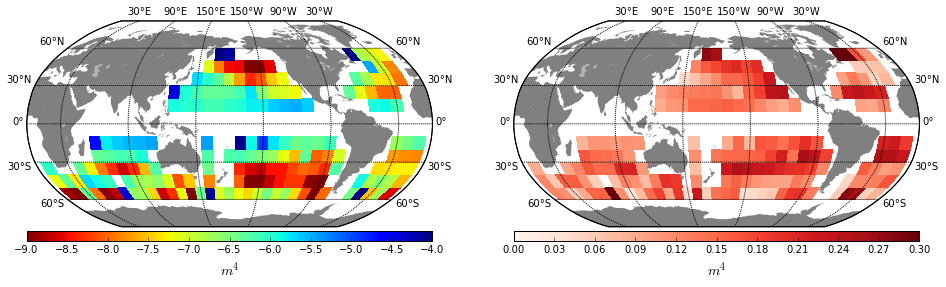

In [35]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopes_year_003), cmap='jet_r')
pc.set_clim([-9.,-4.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopeerr_year_003), cmap='Reds')
pc.set_clim([0.,.3])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

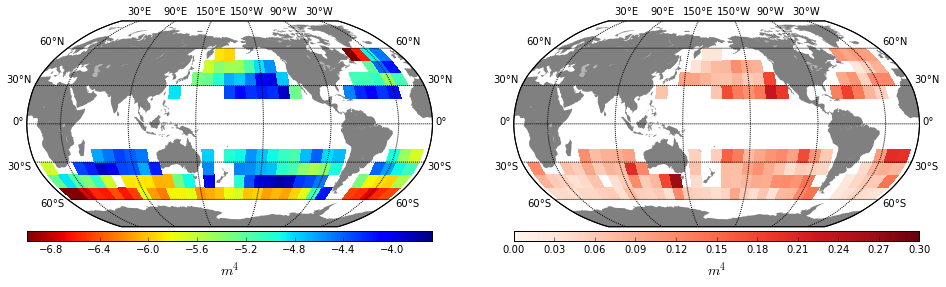

In [36]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopes_year_031), cmap='jet_r')
pc.set_clim([-7.,-11./3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopeerr_year_031), cmap='Reds')
pc.set_clim([0.,.3])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

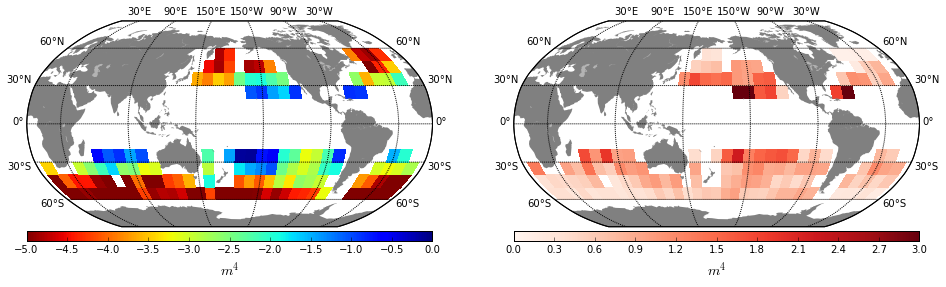

In [37]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopes_year_12), cmap='jet_r')
pc.set_clim([-5.,0.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopeerr_year_12), cmap='Reds')
pc.set_clim([0.,3.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

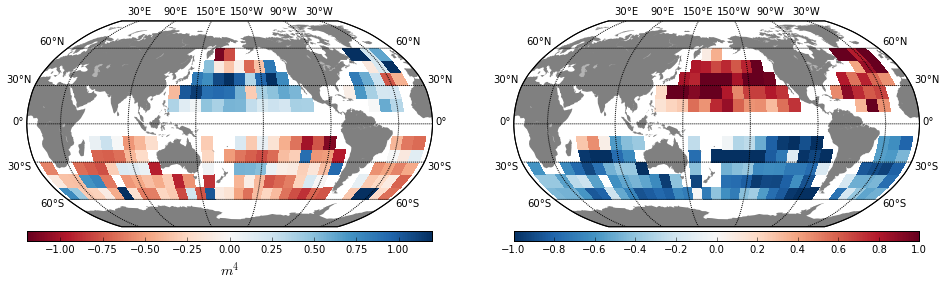

In [42]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopes_win_003 - psd_slopes_sum_003), cmap='RdBu')
pc.set_clim([-1.2,1.2])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(psd_levels_win_003 / psd_levels_sum_003)), cmap='RdBu_r')
pc.set_clim([-1.,1.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
# cbar.set_label('$m^3$', fontsize=14)

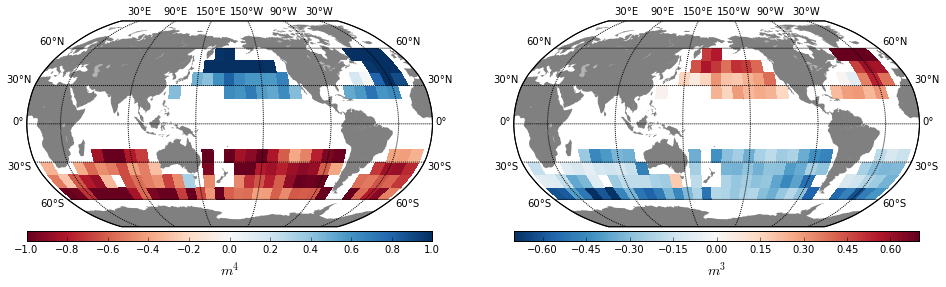

In [39]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopes_win_031 - psd_slopes_sum_031), cmap='RdBu')
pc.set_clim([-1.,1.])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(psd_levels_win_031 / psd_levels_sum_031)), cmap='RdBu_r')
pc.set_clim([-.7,.7])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
# cbar.set_label('$m^3$', fontsize=14)

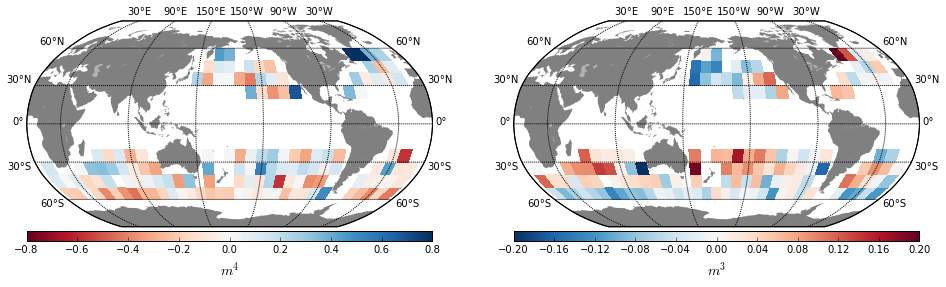

In [40]:
fig = plt.figure(figsize=(16,6))

axi = fig.add_subplot(121)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(psd_slopes_win_12 - psd_slopes_sum_12), cmap='RdBu')
pc.set_clim([-.8,.8])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^4$', fontsize=14)

axi = fig.add_subplot(122)
m.fillcontinents(color='0.5', lake_color='0.7')
m.drawmapboundary(fill_color='none')
x,y = m(Lon,Lat)
pc = m.pcolormesh(x, y, np.ma.masked_invalid(np.log10(psd_levels_win_12 /psd_levels_sum_12)), cmap='RdBu_r')
pc.set_clim([-.2,.2])
m.drawparallels(range(-60,61,30), labels=[1,1,0,0]);
m.drawmeridians(range(30,360,60), labels=[0,0,1,1]);
cbar = m.colorbar(pc, location='bottom')
cbar.set_label('$m^3$', fontsize=14)

In [32]:
# for j in range(Degy+1):
#     for i in range(Degx+1):
#         if np.all(np.isnan(isospecs_ave_sum[(Degx+1)*j+i])) == False and np.all(np.isnan(isospecs_ave_win[(Degx+1)*j+i])) == False:
            
#             plt.figure(figsize=(7,5))
#             #plt.subplot(Degy+1,Degx+1,(Degx+1)*j+i+1)
#             plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, isospecs_ave_sum[(Degx+1)*j+i], 'r', label=r'Summer' )
#             plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, isospecs_ave_win[(Degx+1)*j+i], 'b', label=r'Winter' )
            
#             if np.all( np.isnan(psd_fit_sum_01[r:,j,i]) ) == False or np.all( np.isnan(psd_fit_win_01[r:,j,i]) ) == False:
#                 plt.loglog( Kis[(Degx+1)*j+i, r:]*.5/np.pi*1e3, psd_fit_sum_01[r:,j,i], 'k' )
#                 plt.loglog( Kis[(Degx+1)*j+i, r:]*.5/np.pi*1e3, psd_fit_win_01[r:,j,i], 'k' )
#             else:
#                 print 'No plot of fit between 0-1 radii'
                
#             if np.all( np.isnan(psd_fit_sum_12[r2:r+1,j,i]) ) == False or np.all( np.isnan(psd_fit_win_12[r2:r+1,j,i]) ) == False:
#                 plt.loglog( Kis[(Degx+1)*j+i, r2:r+1]*.5/np.pi*1e3, psd_fit_sum_12[r2:r+1,j,i], 'k' )
#                 plt.loglog( Kis[(Degx+1)*j+i, r2:r+1]*.5/np.pi*1e3, psd_fit_win_12[r2:r+1,j,i], 'k' )
#             else:
#                 print 'No plot of fit between 1-2 radii'
                
#             if np.all( np.isnan(psd_fit_sum_23[r3:r2+1,j,i]) ) == False or np.all( np.isnan(psd_fit_win_23[r3:r2+1,j,i]) ) == False:
#                 plt.loglog( Kis[(Degx+1)*j+i, r3:r2+1]*.5/np.pi*1e3, psd_fit_sum_23[r3:r2+1,j,i], 'k' )
#                 plt.loglog( Kis[(Degx+1)*j+i, r3:r2+1]*.5/np.pi*1e3, psd_fit_win_23[r3:r2+1,j,i], 'k' )
#             else:
#                 print 'No plot of fit between 2-3 radii'
                
#             plt.legend(loc='lower left', fontsize=14)
#             plt.title('lat: [%g, %g], lon: [%g, %g]' % (Lat[j,0], Lat[j+1,0], Lon[0,i], Lon[0,i+1]), fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             plt.xlabel('Inverse Wavelength [$km^{-1}$]', fontsize=14)
#             plt.ylabel('[$m^3$]', fontsize=14)
#             plt.show()

In [33]:
alpha = 0.05
aWin, bWin = stats.chi2.ppf([1-alpha*0.5, alpha*0.5], 2*(Neff_Jan + Neff_Feb + Neff_Mar))     # 1-2*(alpha/2) = 1-alpha = p
aSum, bSum = stats.chi2.ppf([1-alpha*0.5, alpha*0.5], 2*(Neff_Jul + Neff_Aug + Neff_Sep))
print aWin, bWin, aSum, bSum

#interval_winter = 2*N_eff_winter.sum()*(1/aWin-1/bWin)
#err_winter = 2*N_eff_winter.sum()*np.array([1/aWin, 1/bWin])
#interval_winter = 2*N_eff_summer.sum()*(1/aSum-1/bSum)
#err_summer = 2*N_eff_summer.sum()*np.array([1/aSum, 1/bSum])
err_bar = 2*(Neff_Jul + Neff_Aug + Neff_Sep)*np.array([1/aSum, 1/bSum])

815.175399558 664.61247328 815.175399558 664.61247328


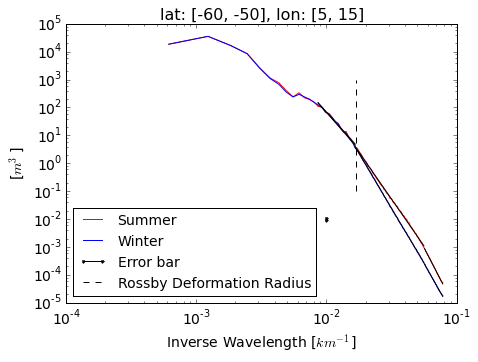

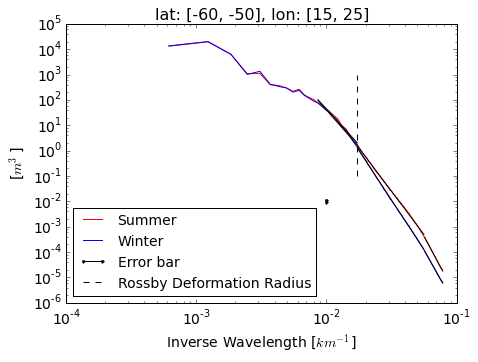

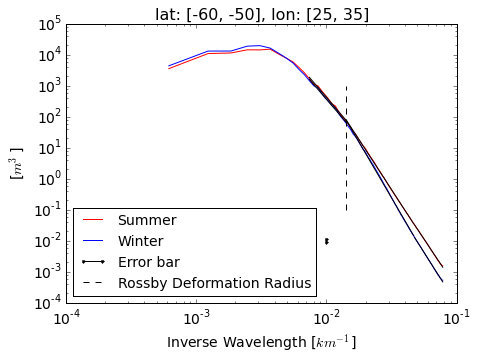

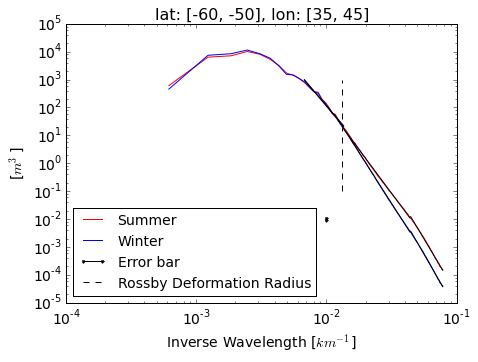

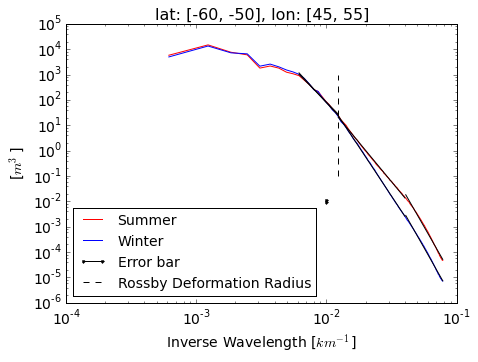

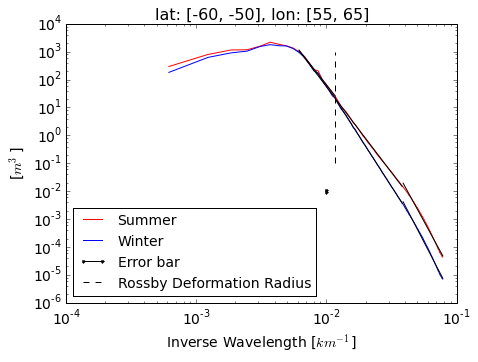

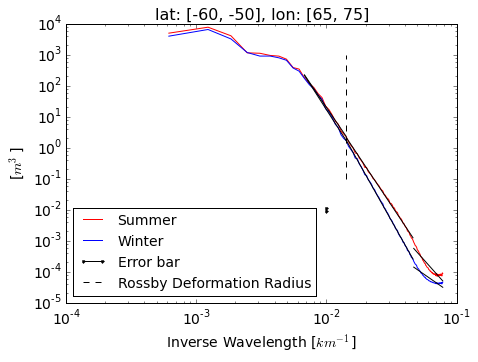

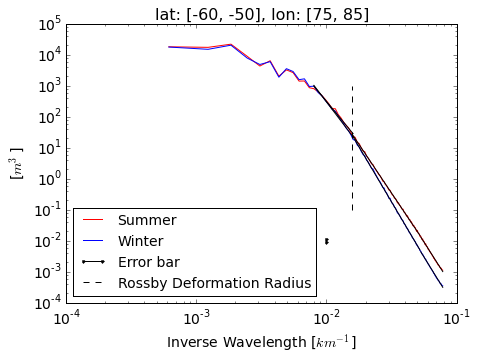

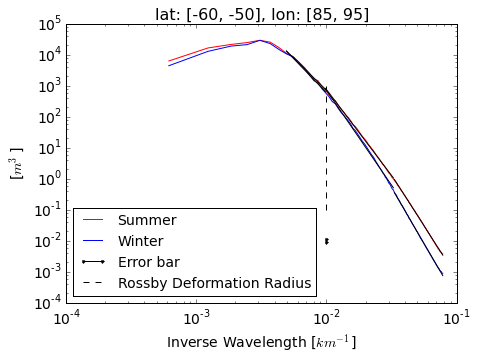

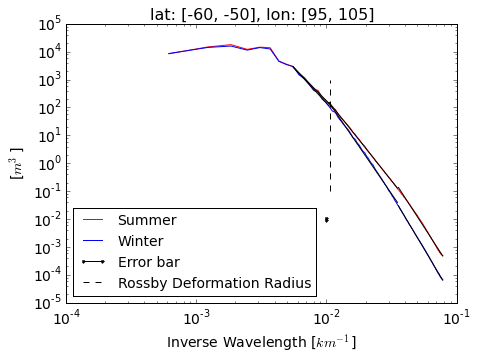

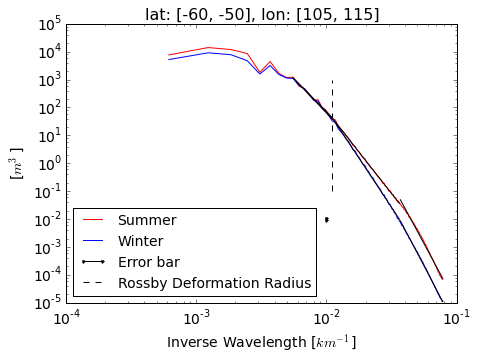

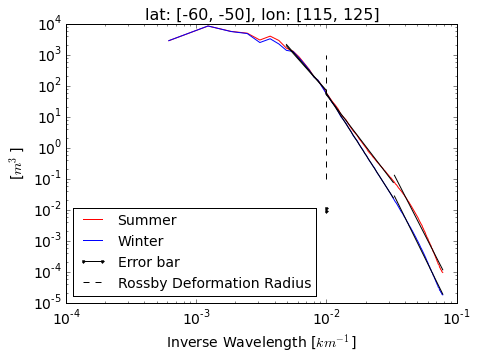

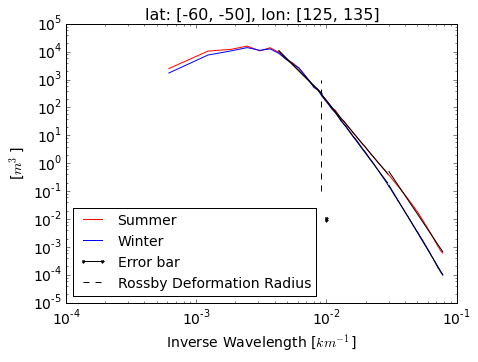

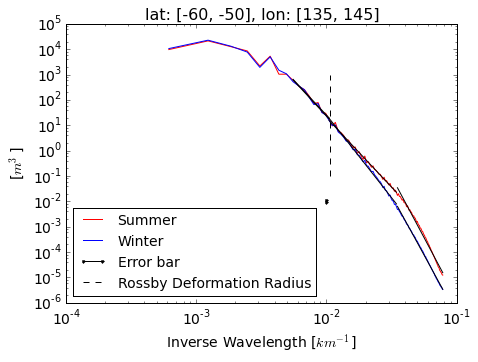

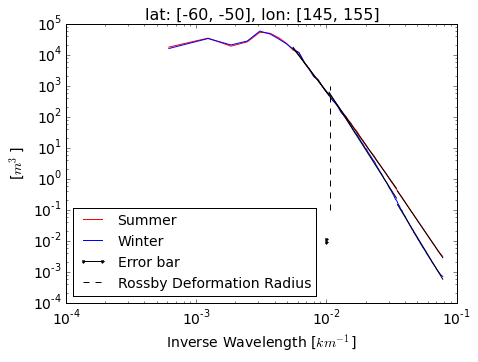

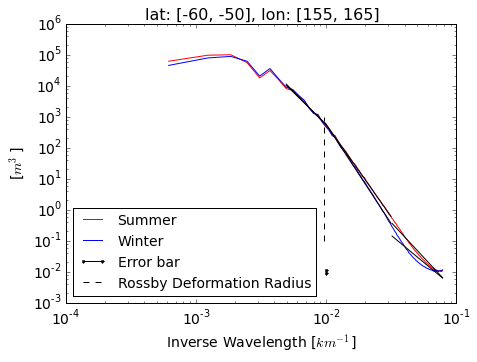

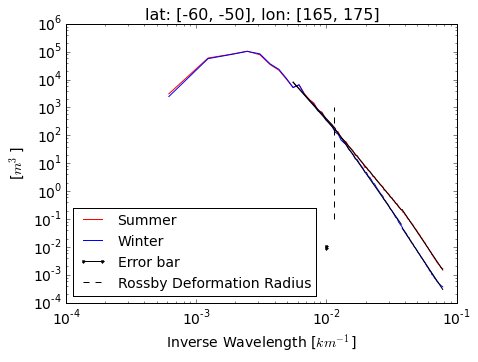

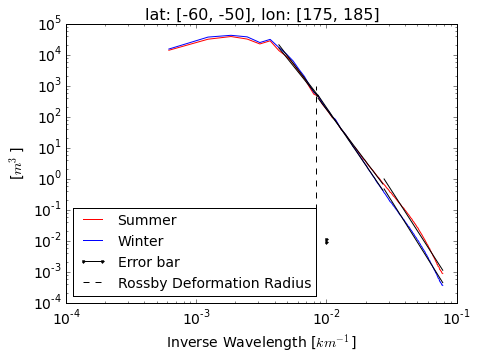

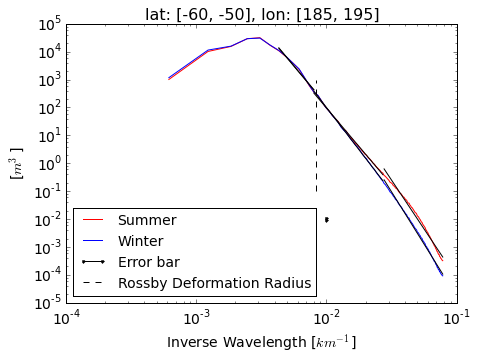

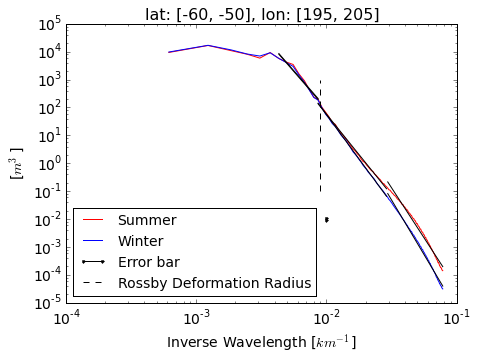

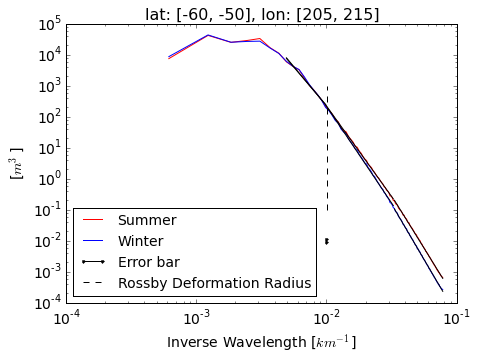

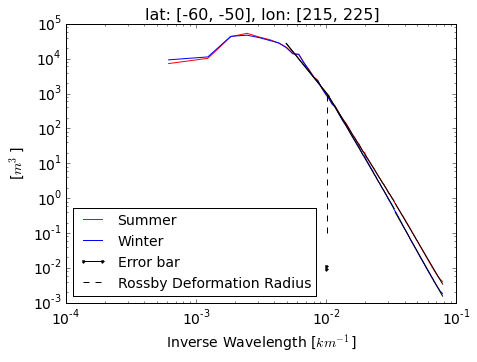

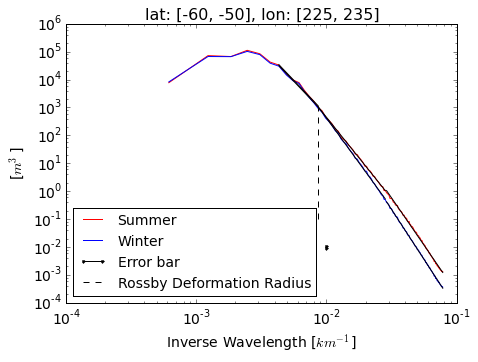

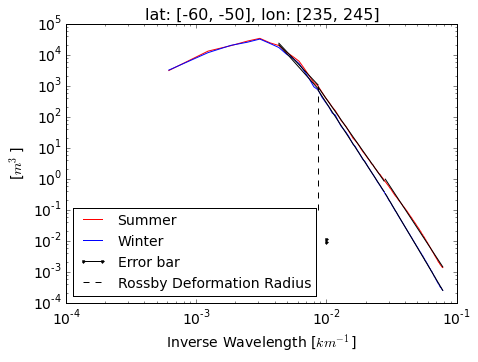

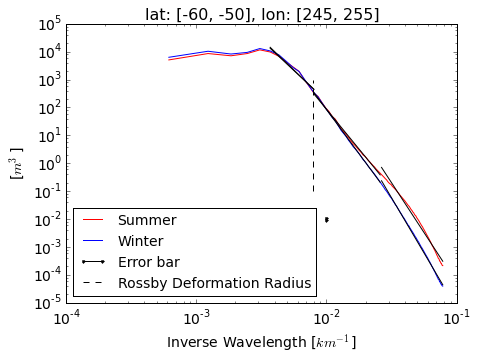

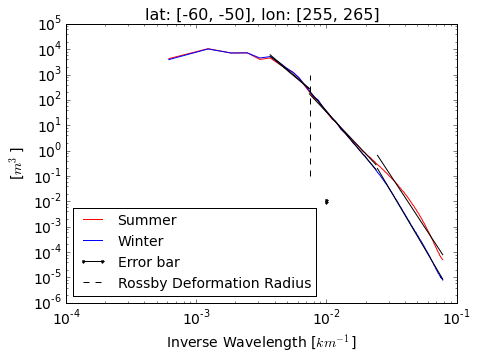

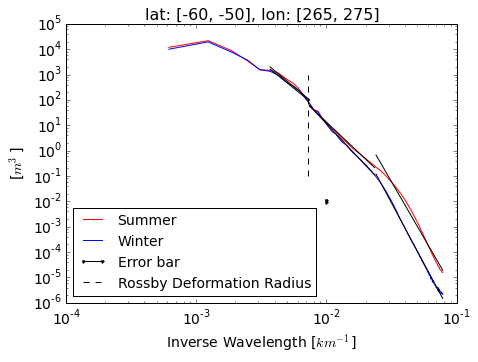

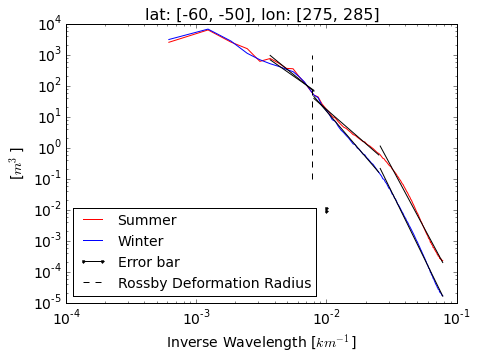

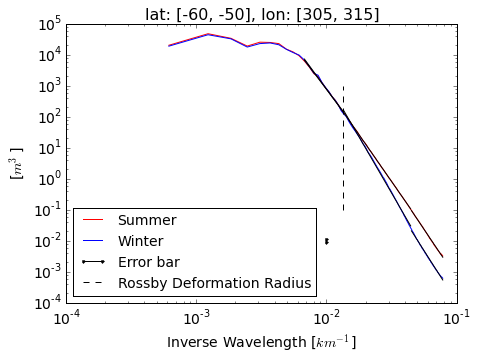

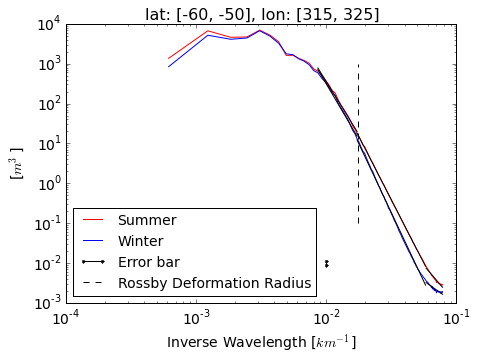

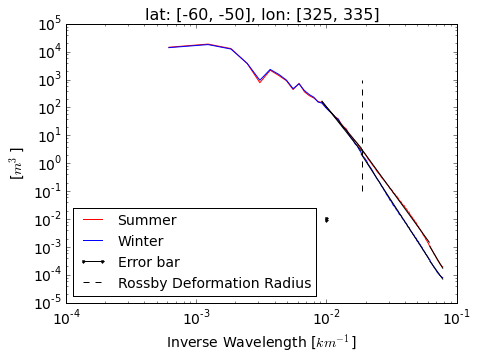

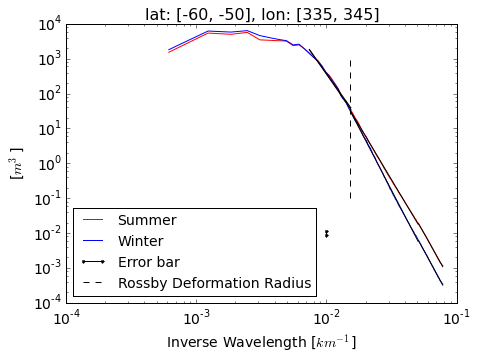

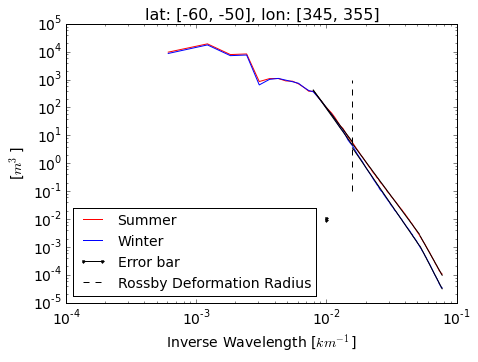

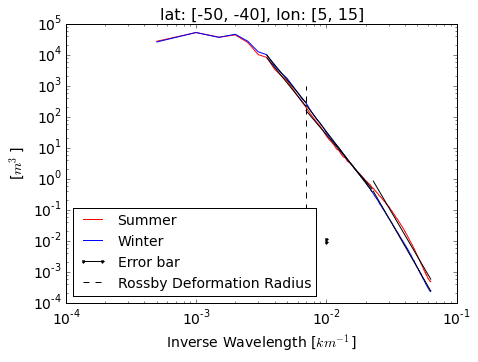

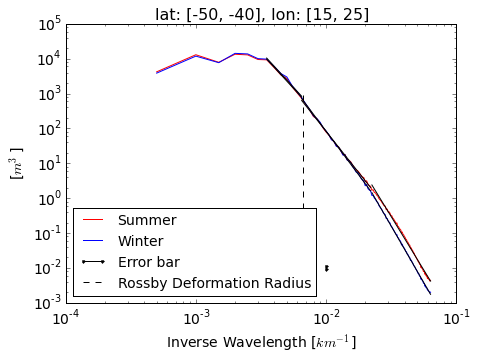

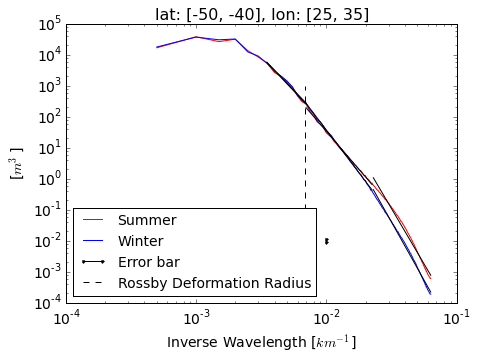

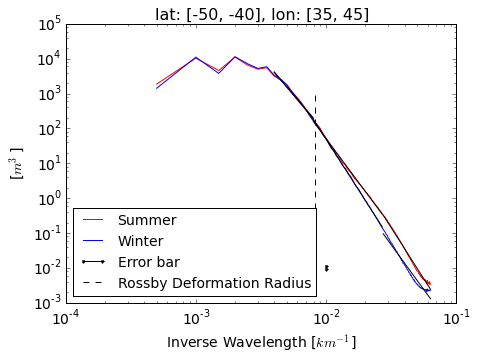

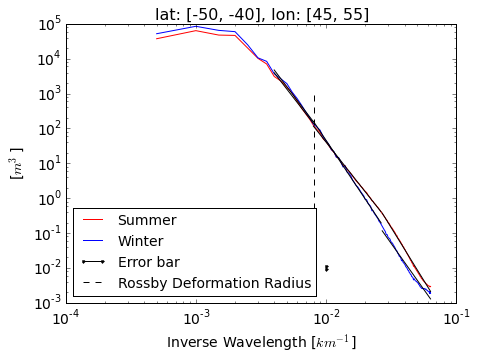

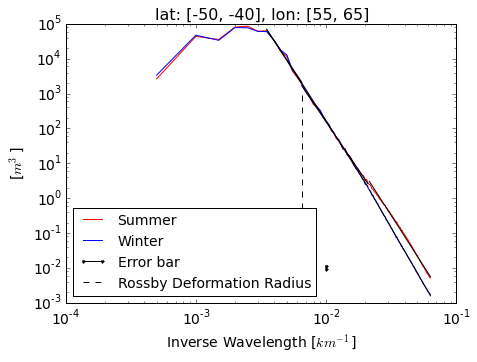

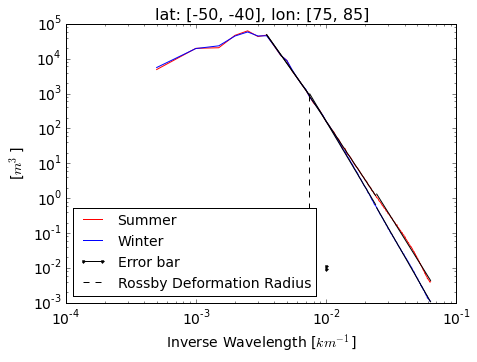

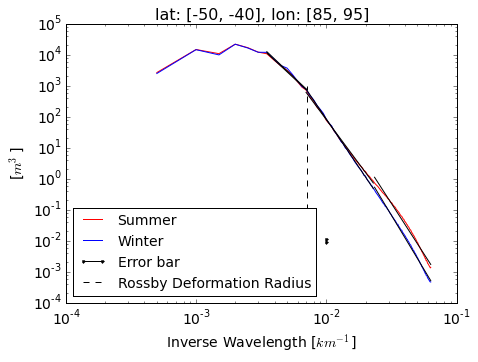

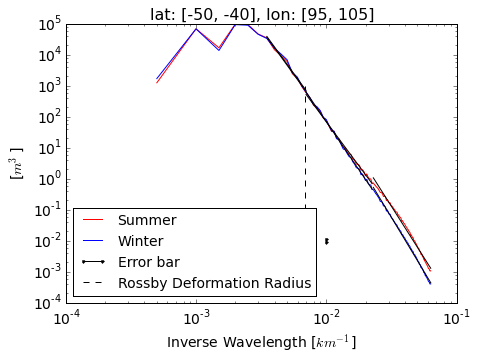

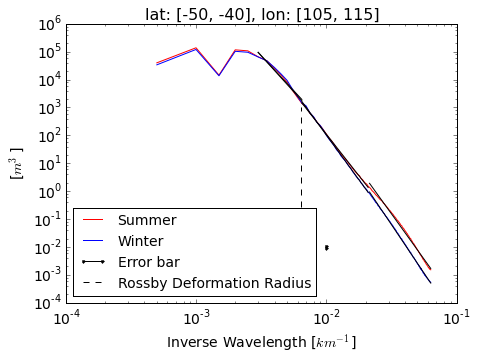

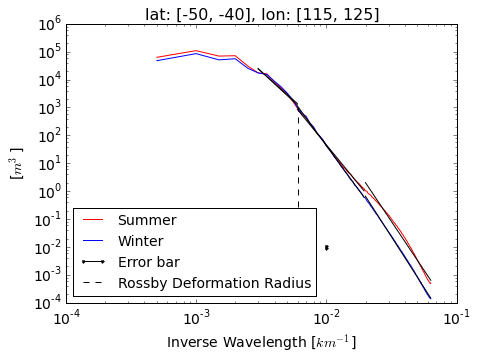

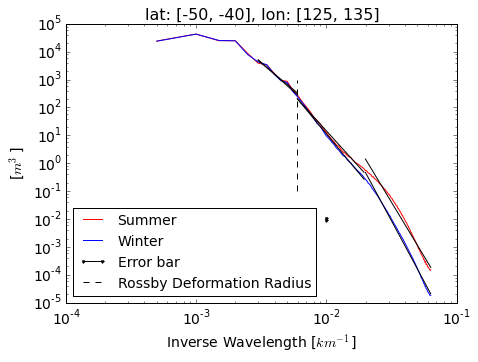

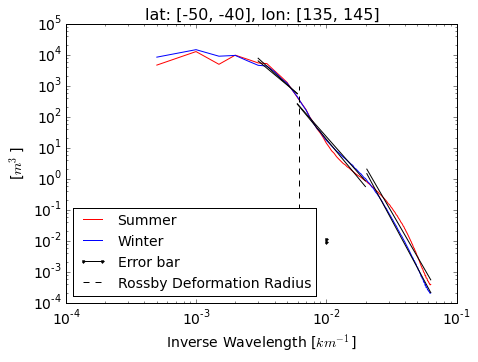

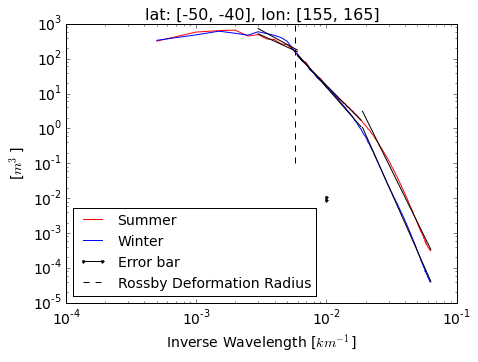

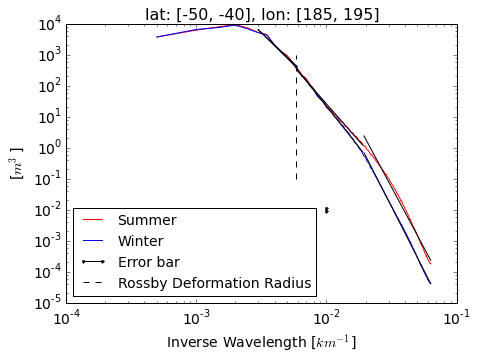

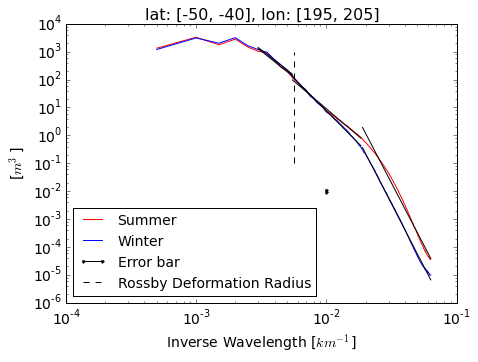

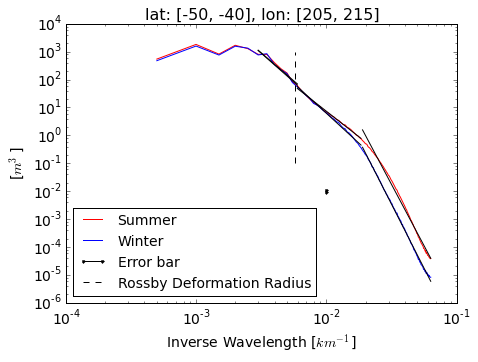

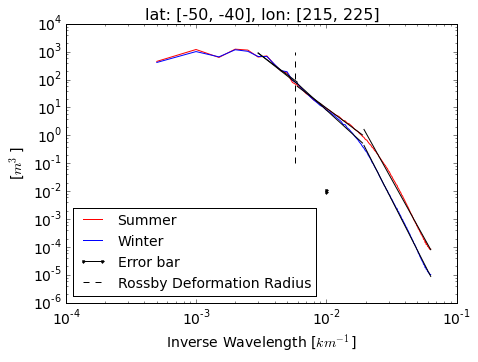

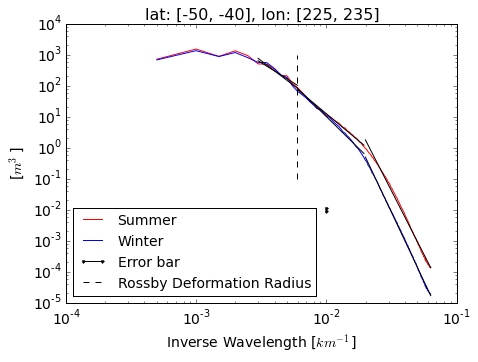

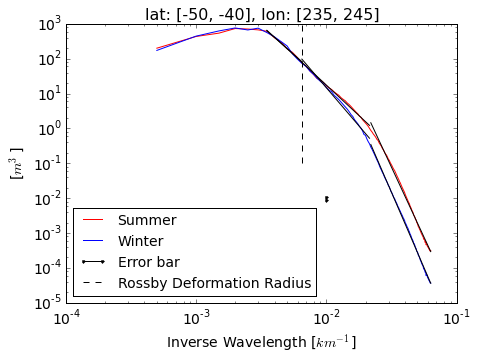

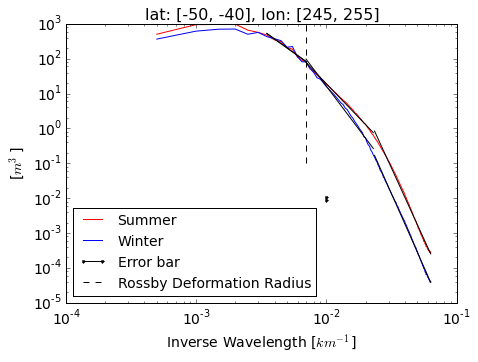

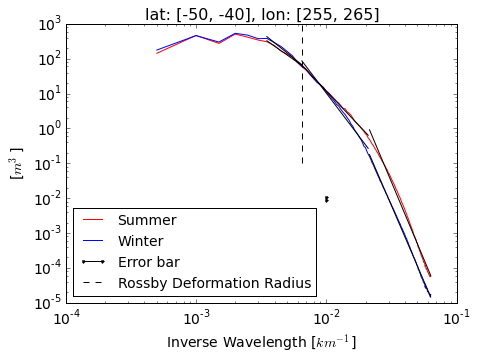

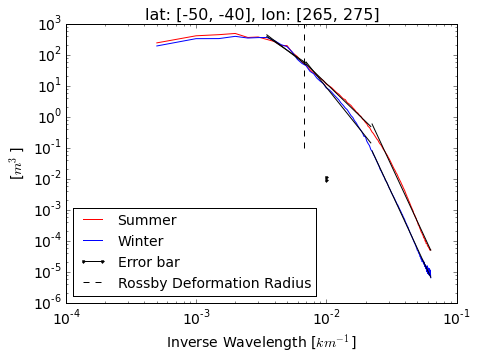

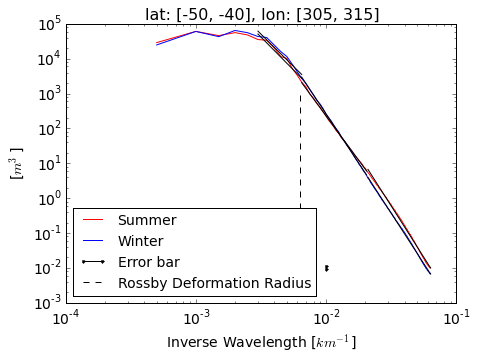

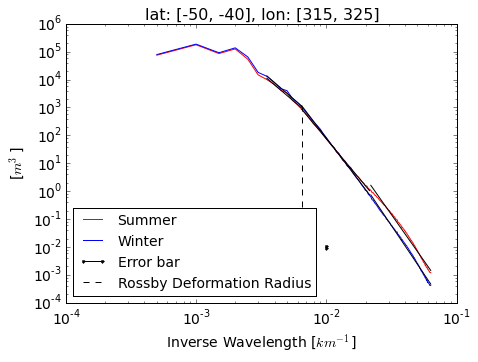

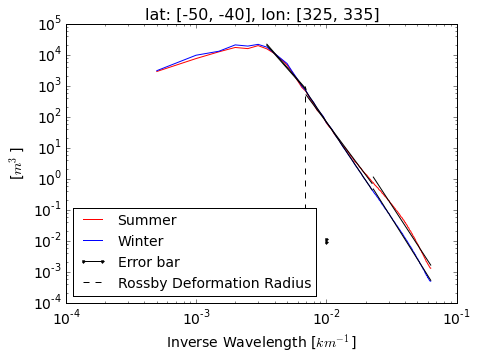

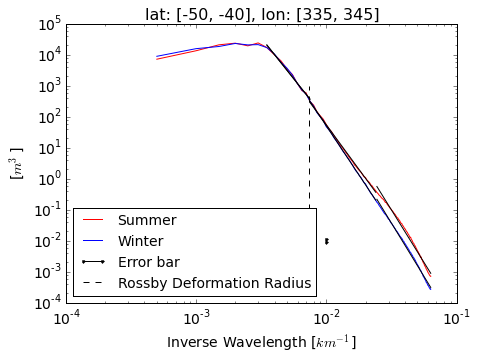

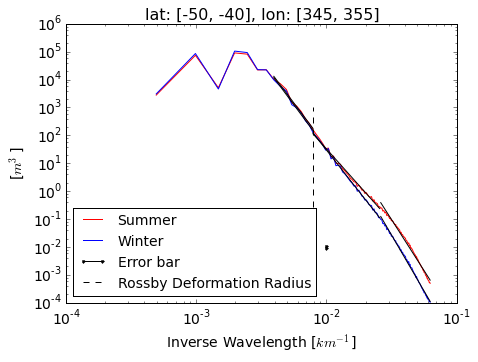

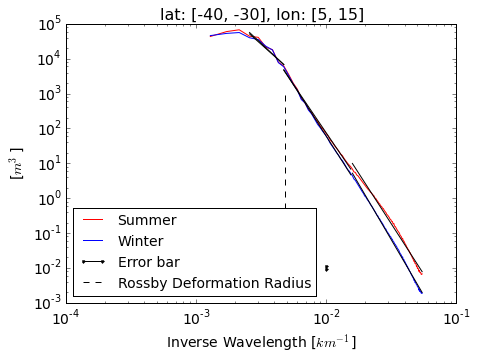

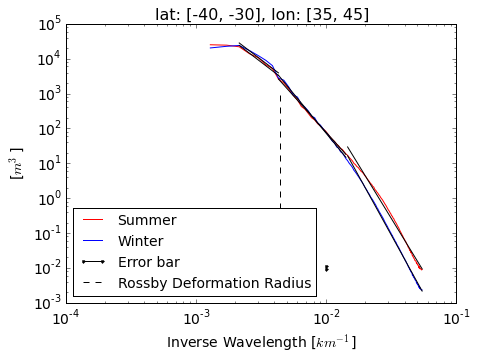

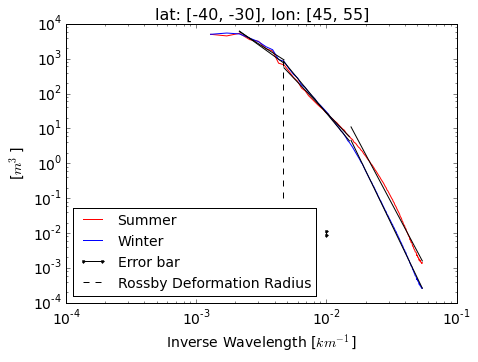

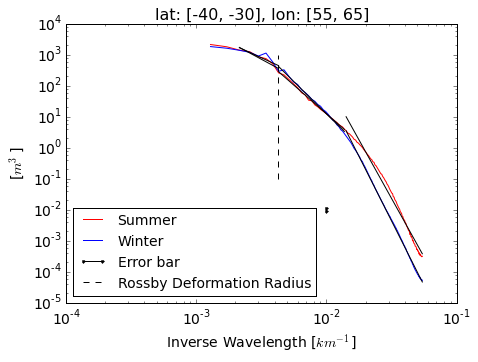

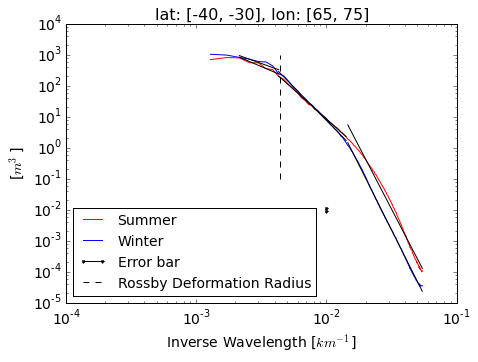

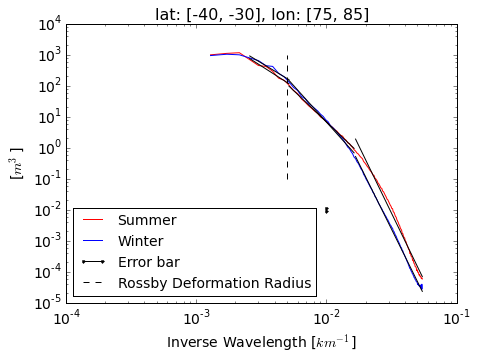

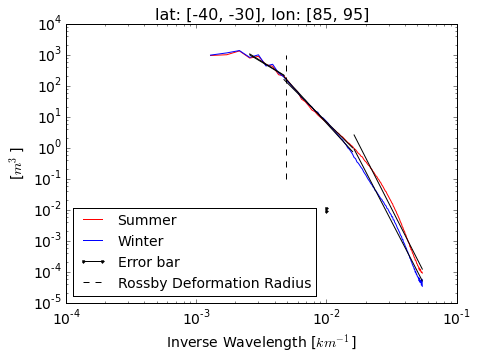

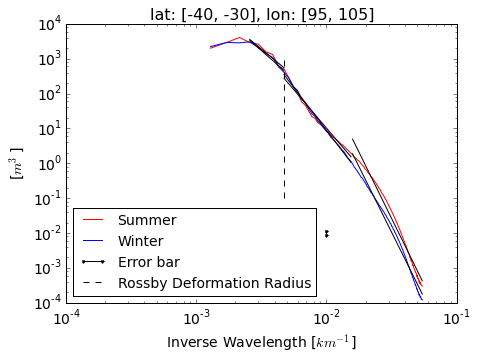

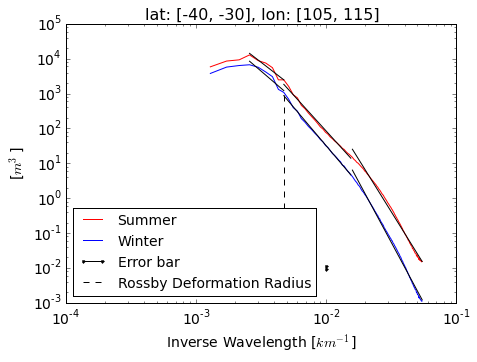

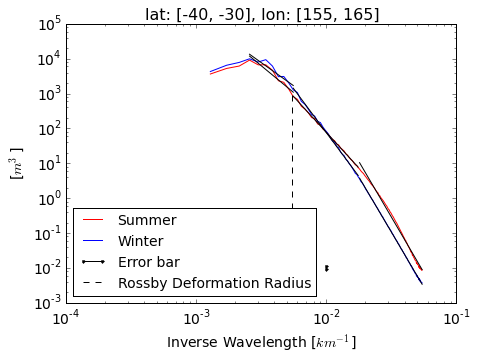

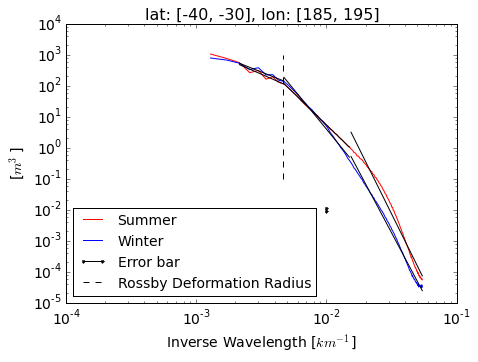

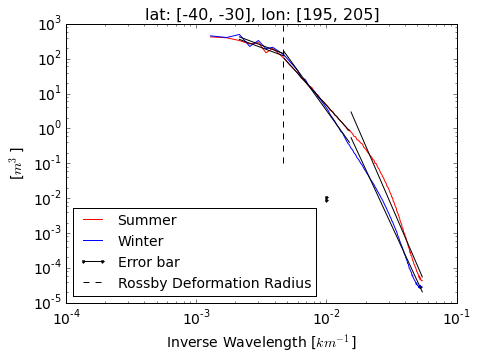

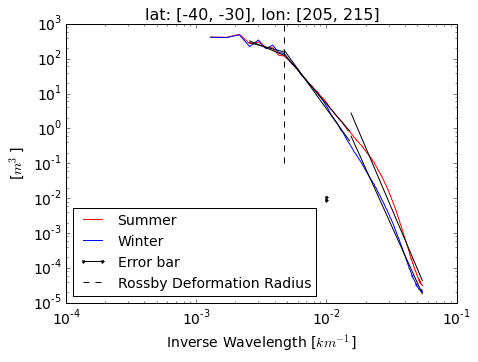

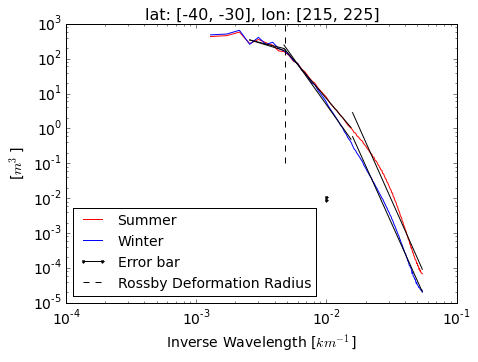

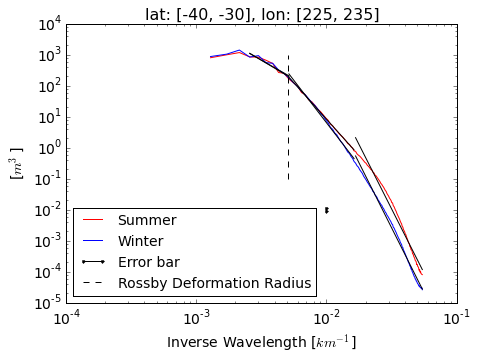

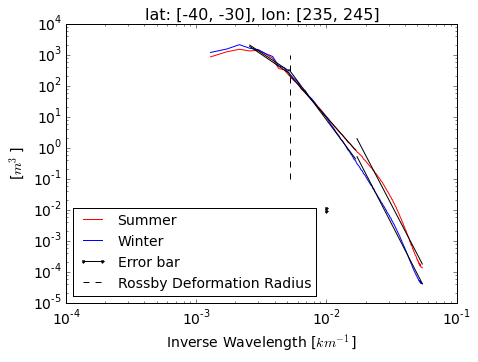

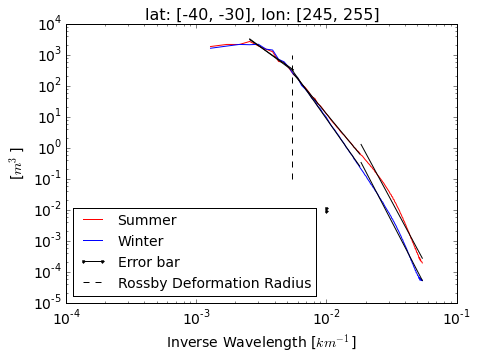

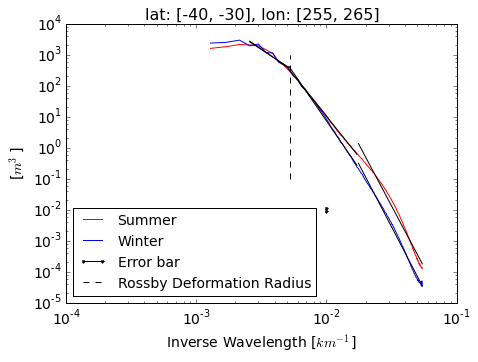

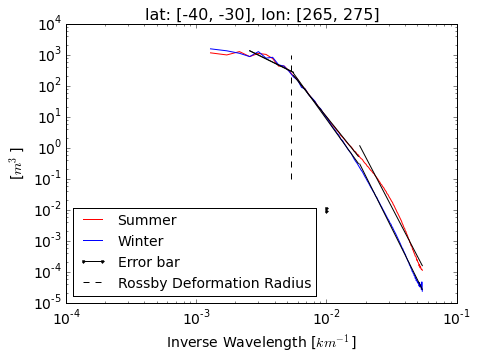

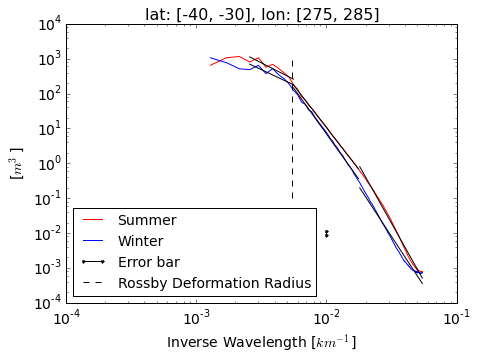

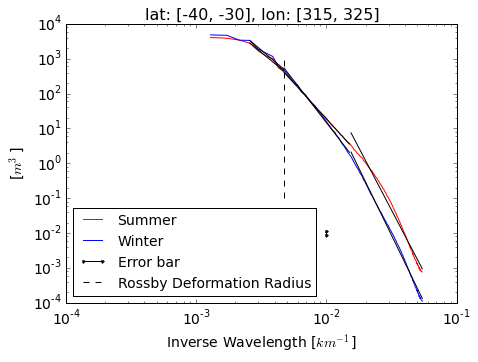

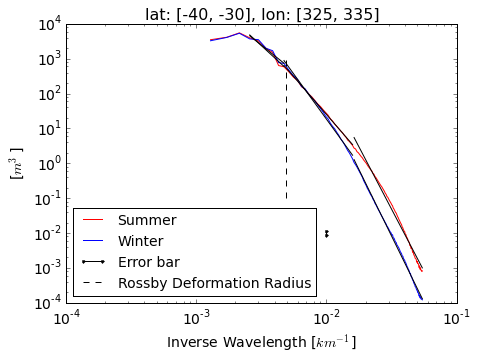

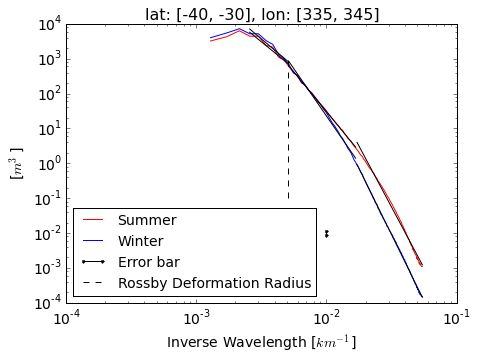

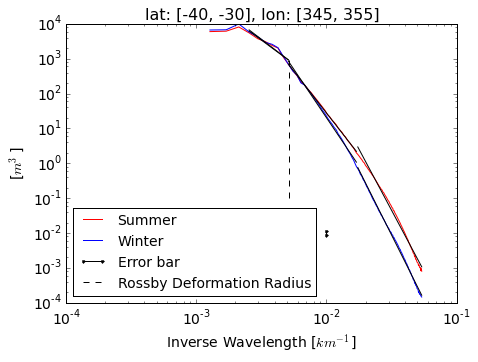

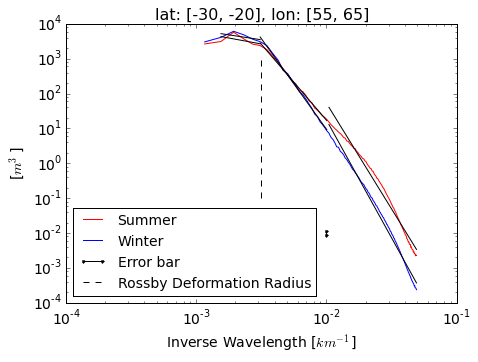

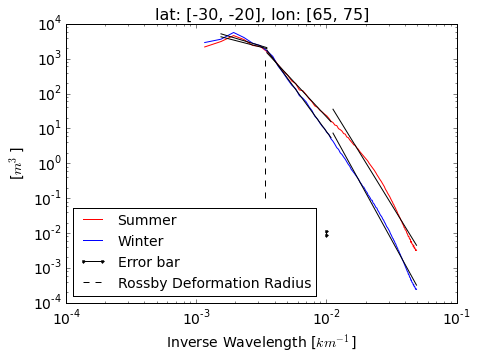

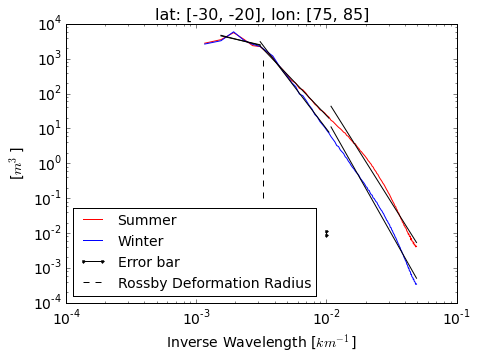

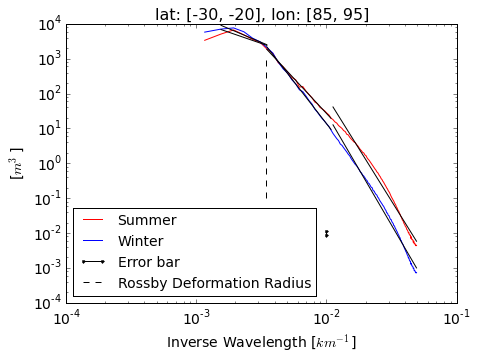

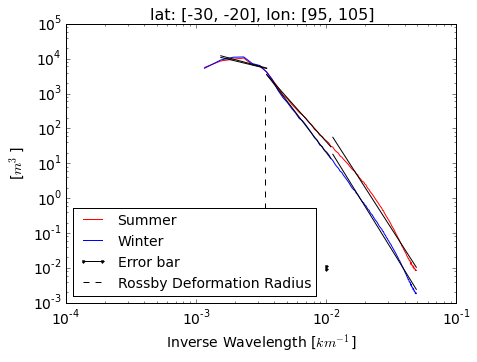

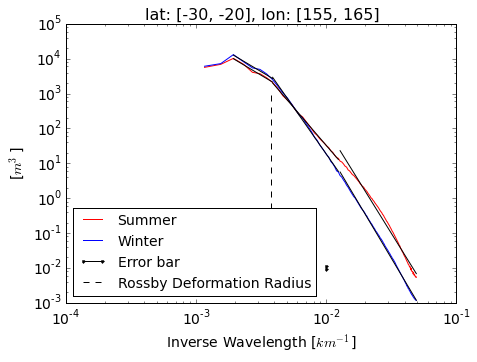

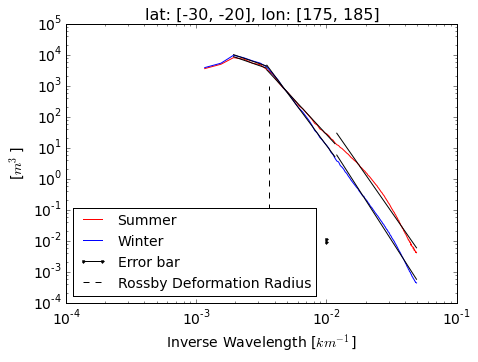

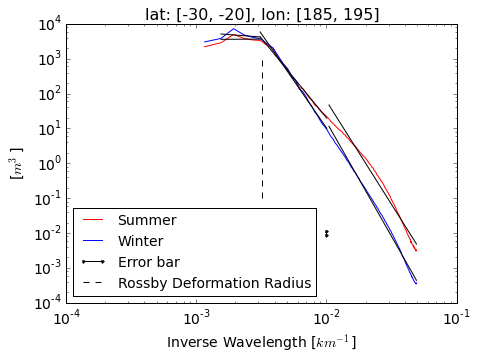

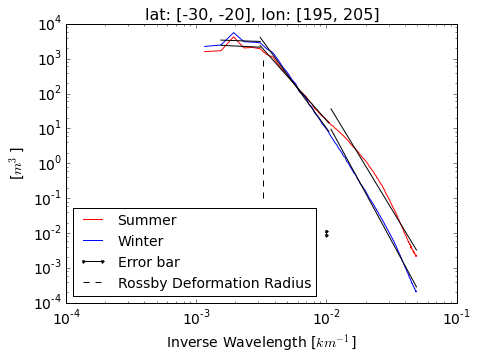

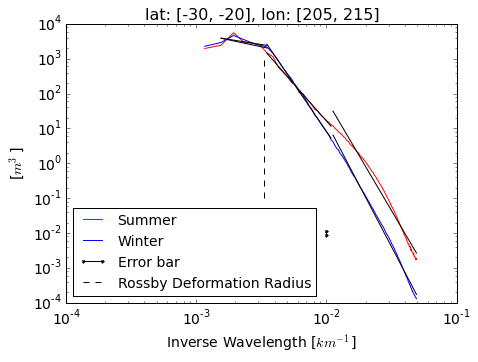

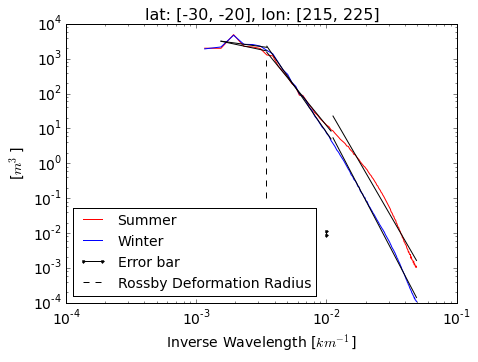

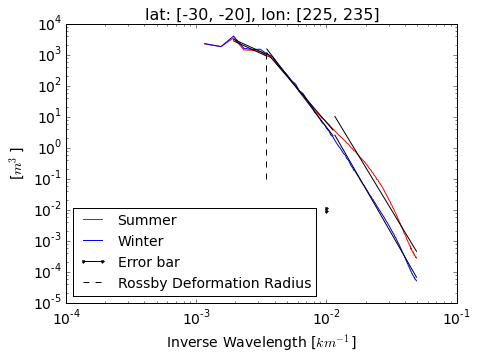

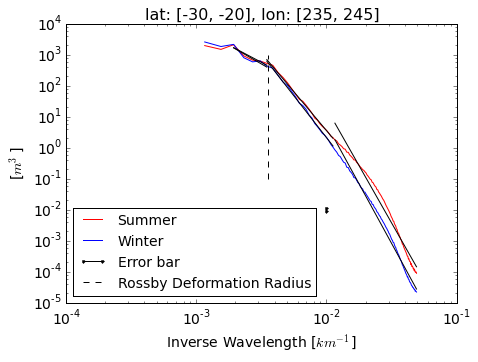

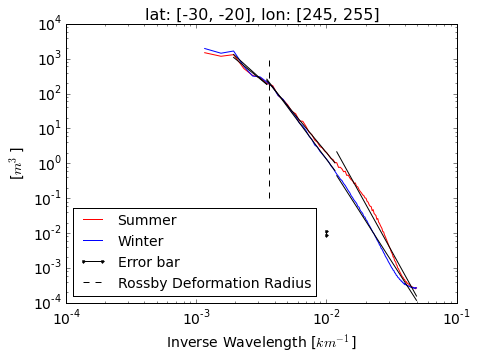

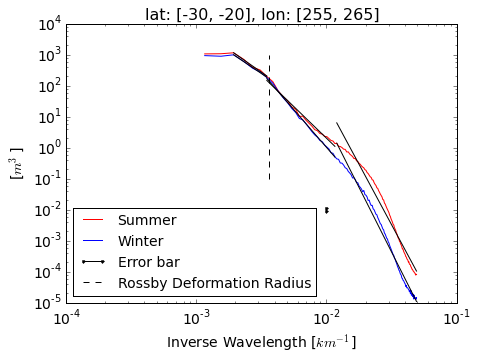

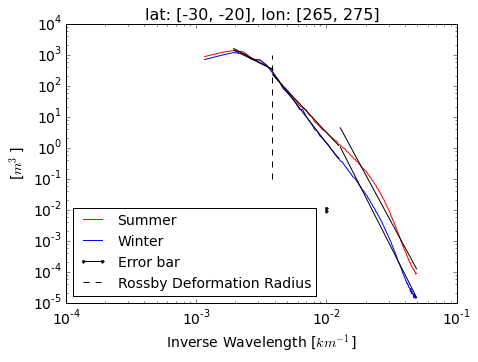

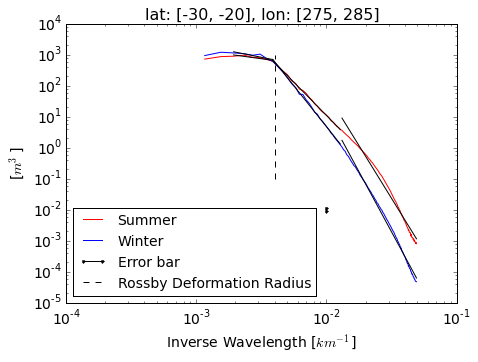

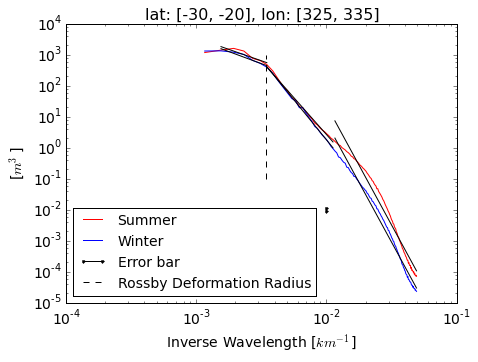

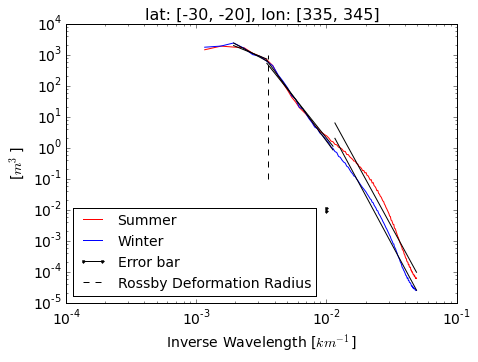

No plot of fit between 1-2 radii


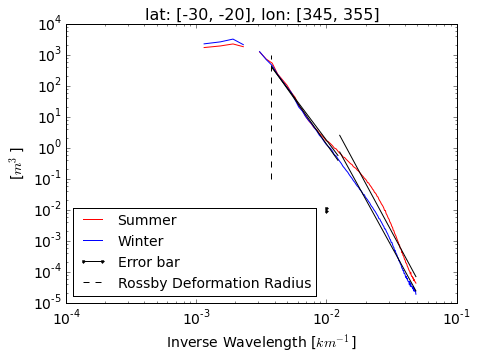

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


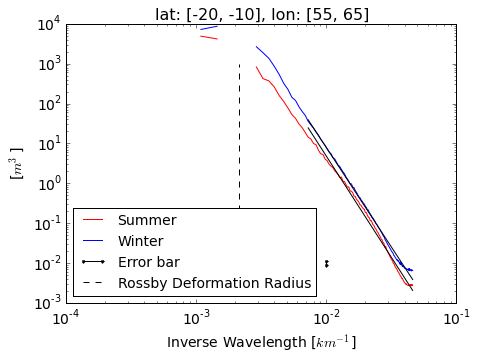

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


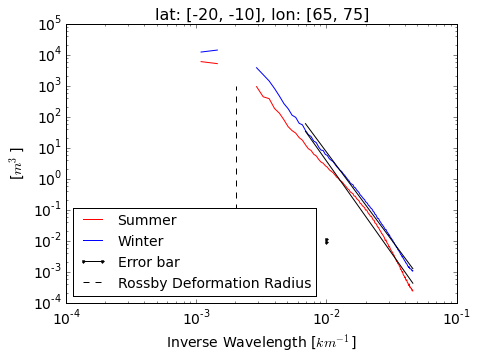

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


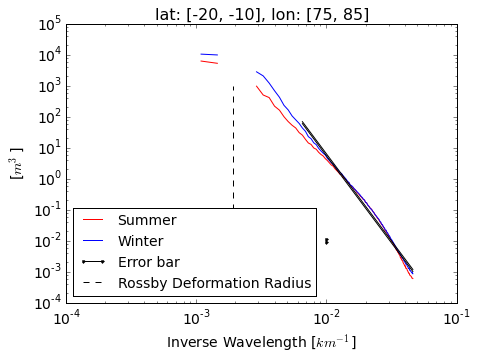

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


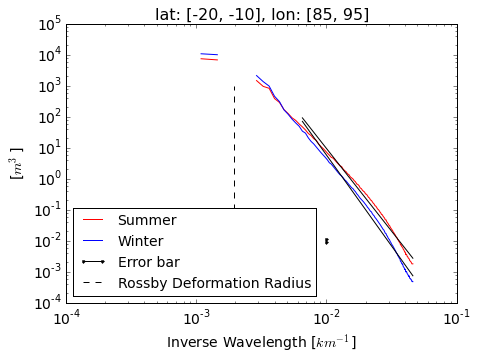

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


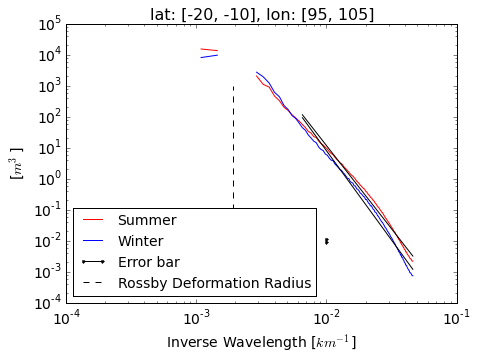

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


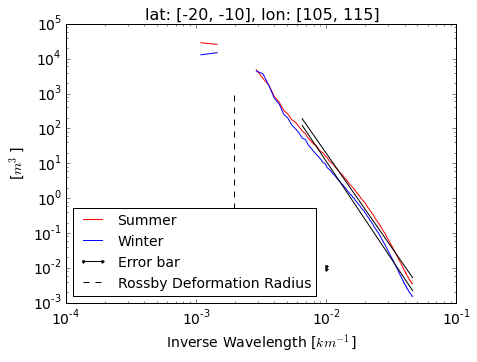

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


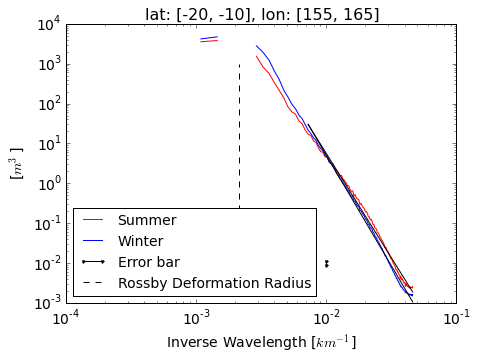

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


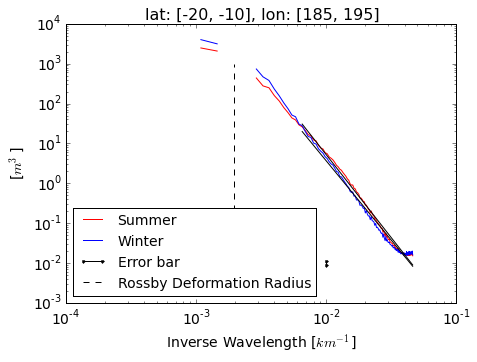

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


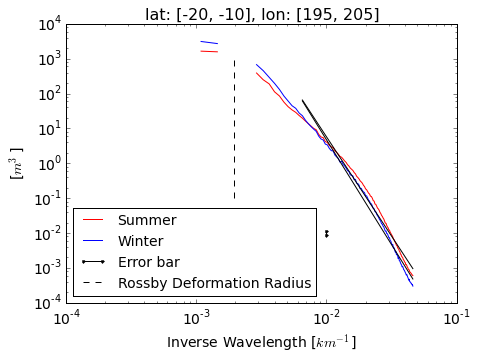

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


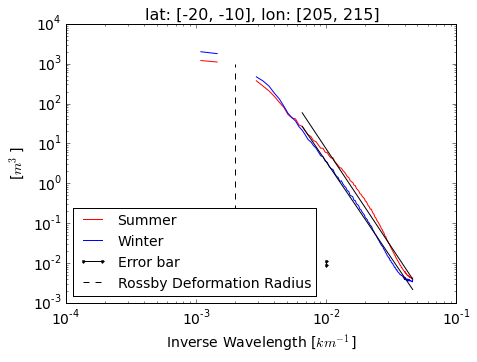

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


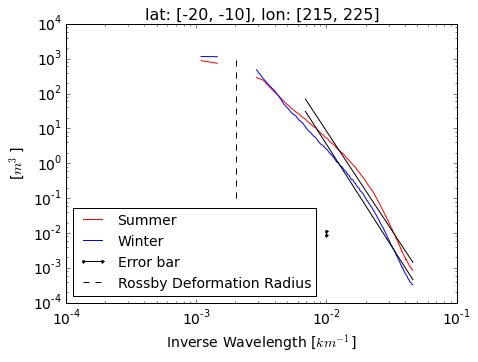

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


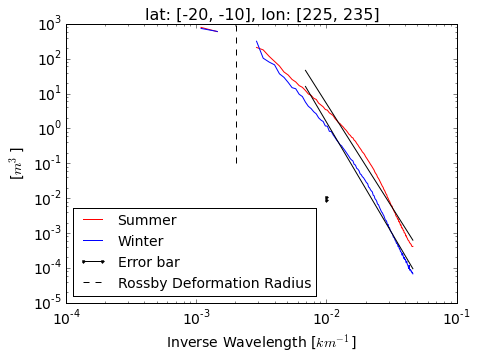

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


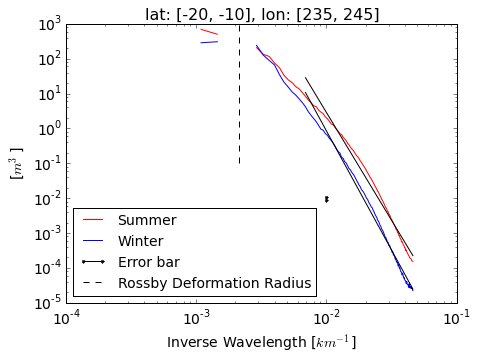

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


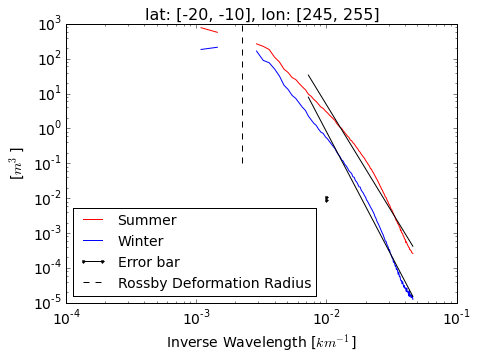

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


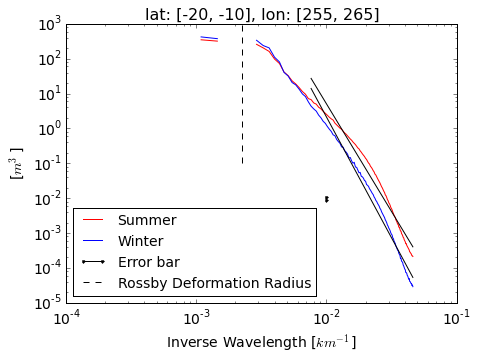

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


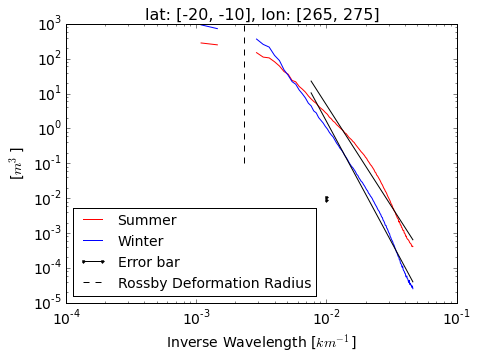

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


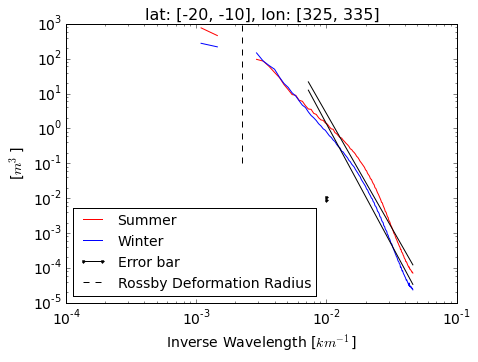

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


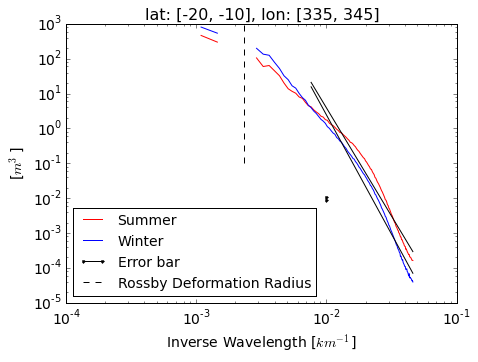

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


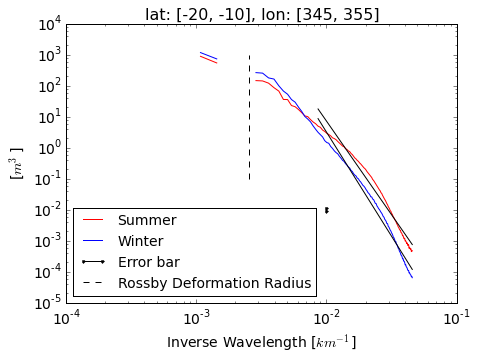

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


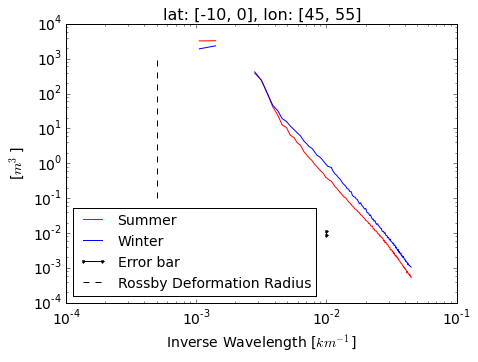

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


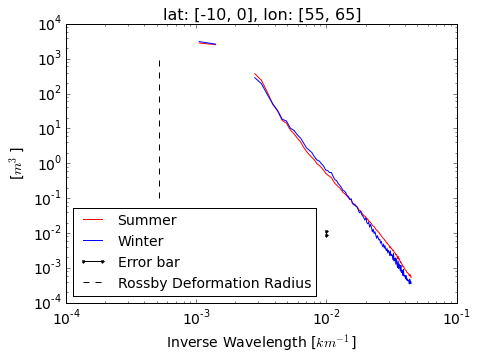

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


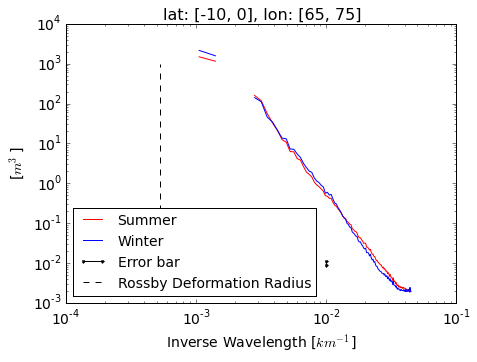

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


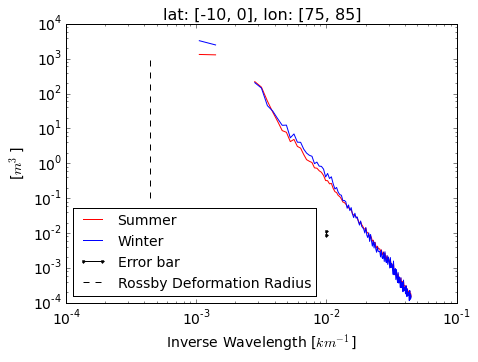

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


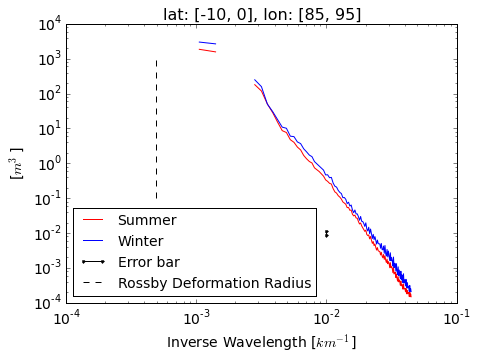

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


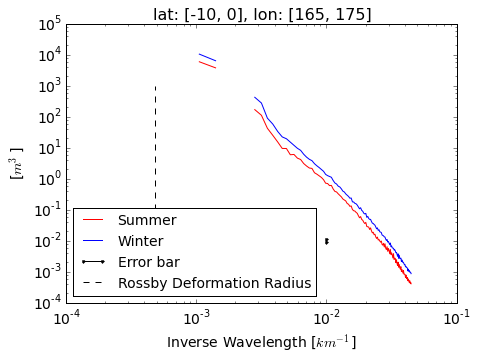

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


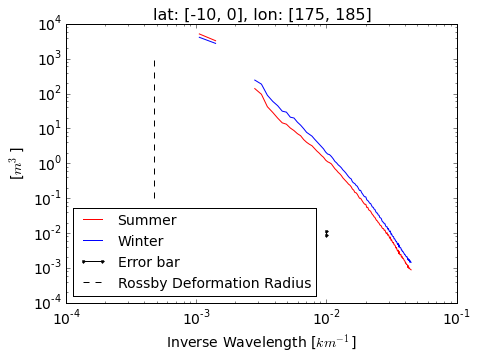

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


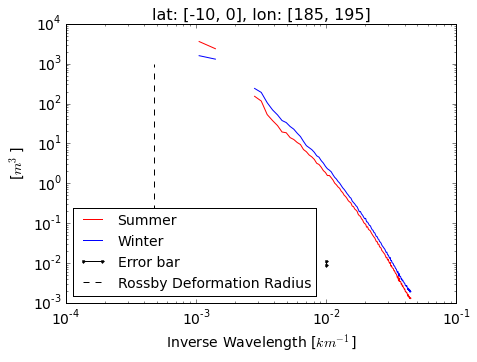

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


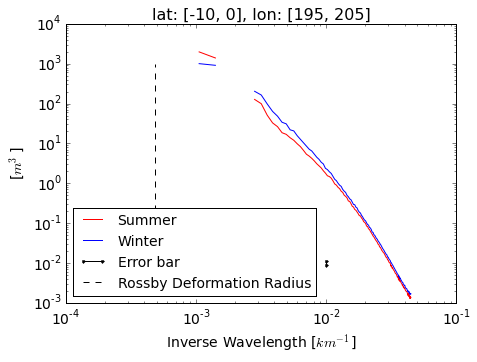

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


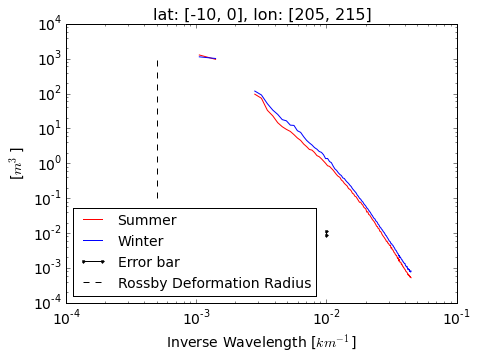

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


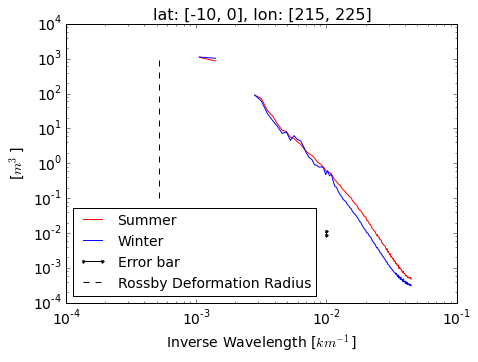

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


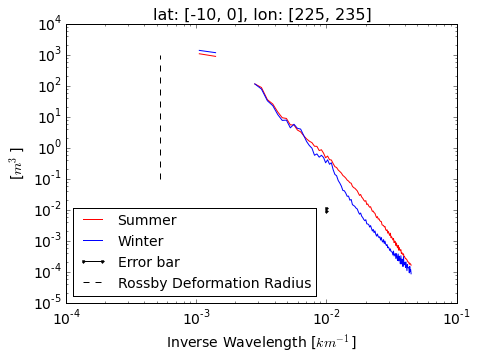

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


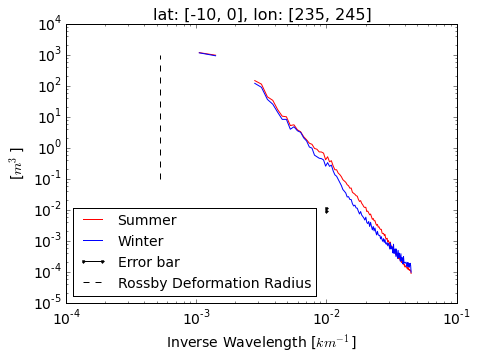

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


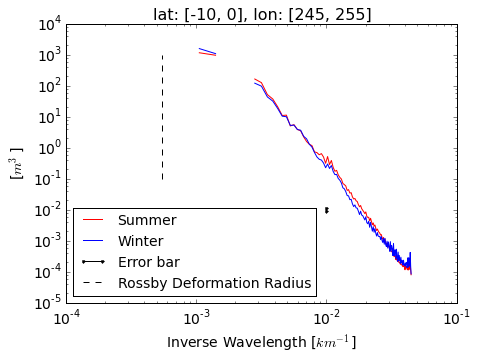

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


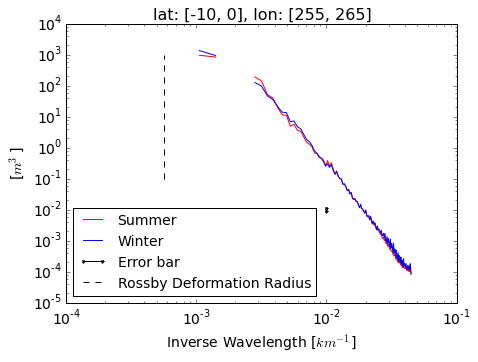

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


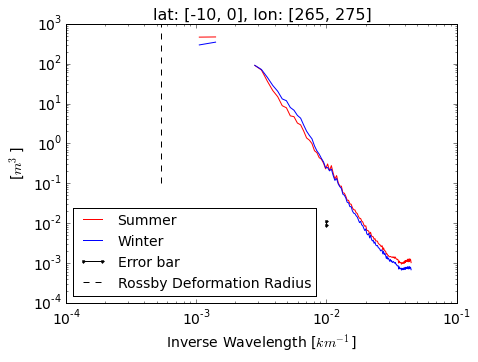

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


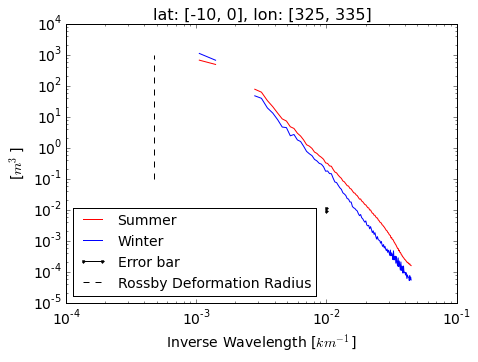

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


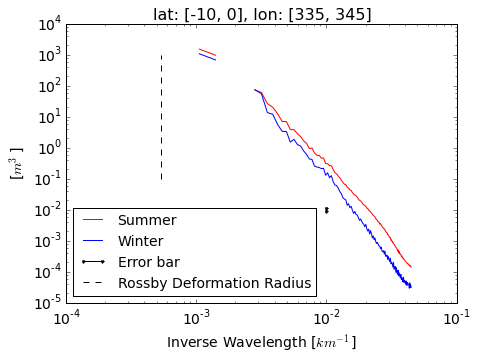

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


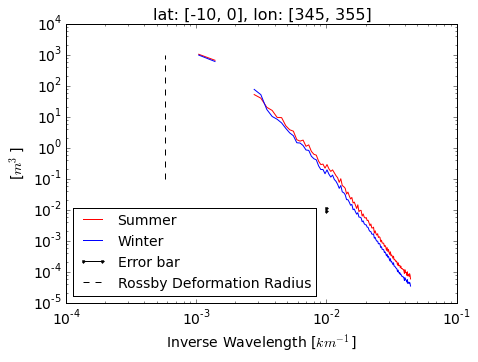

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


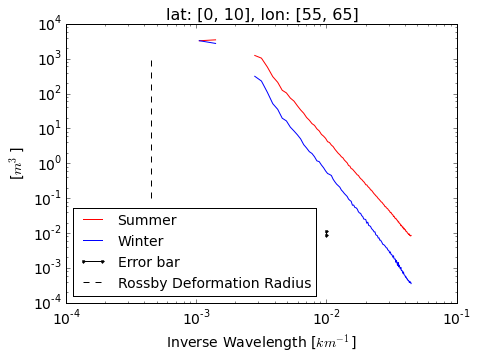

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


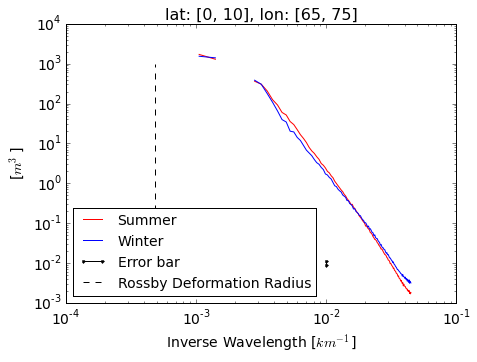

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


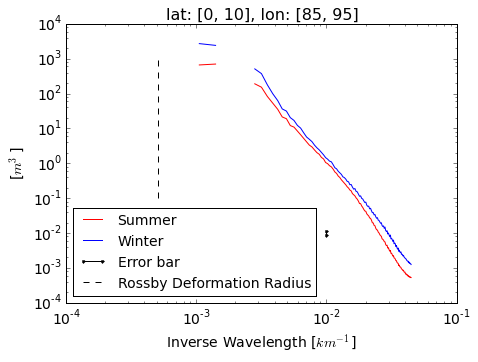

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


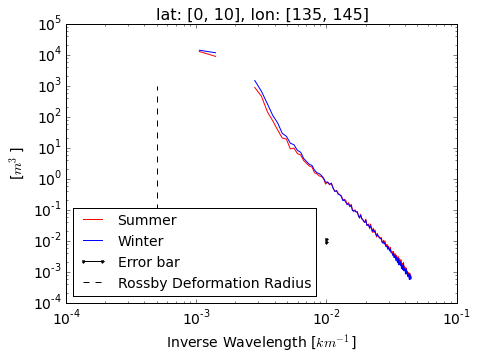

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


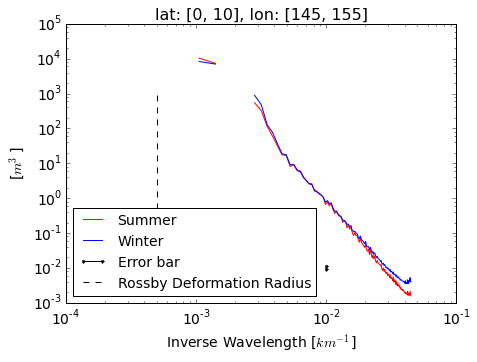

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


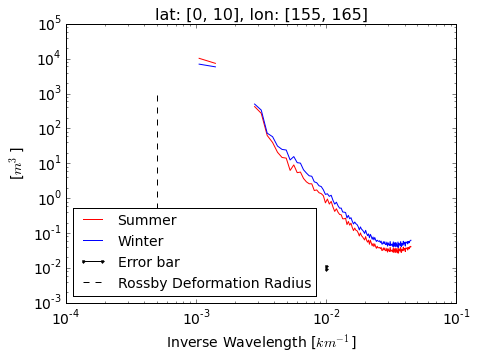

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


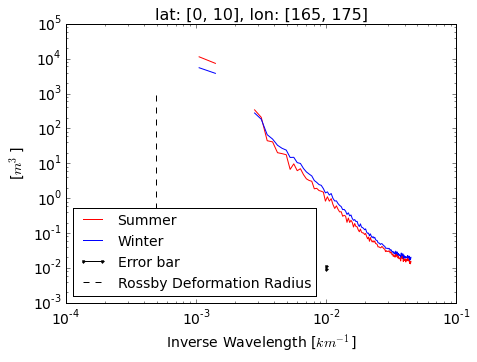

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


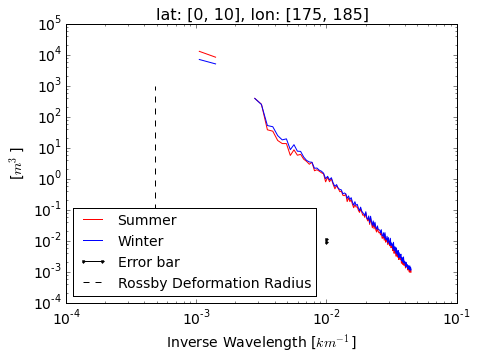

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


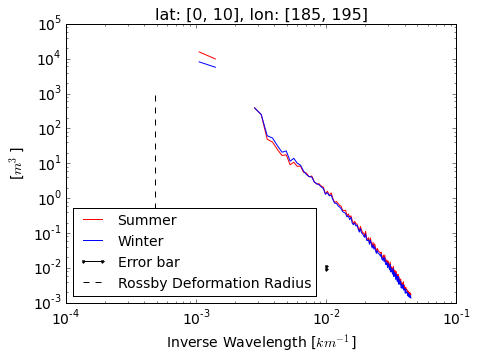

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


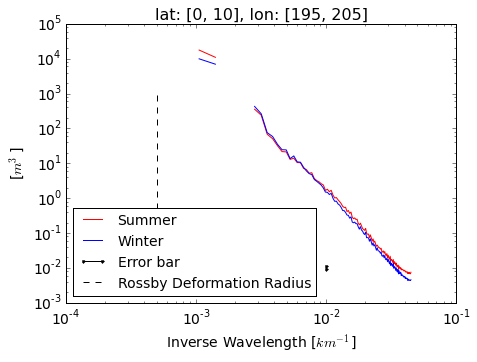

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


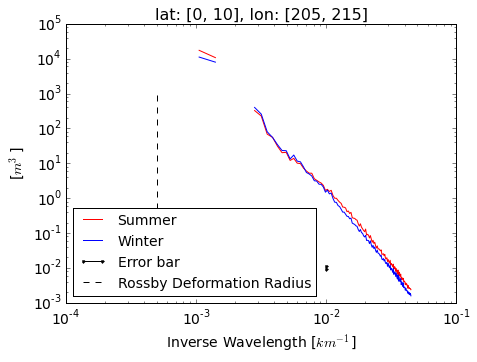

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


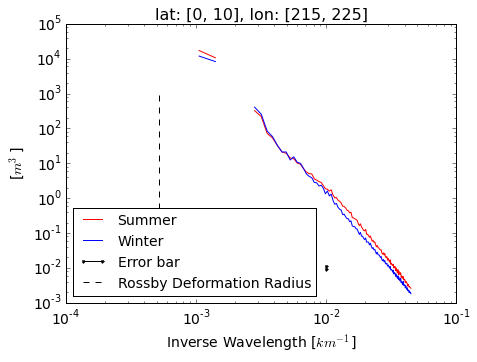

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


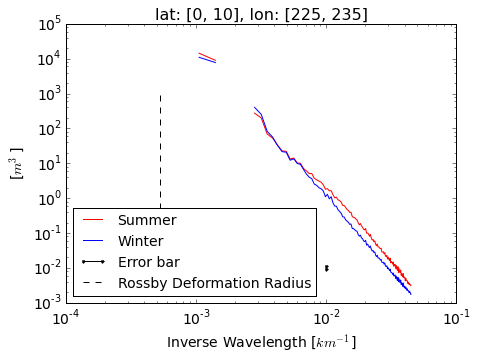

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


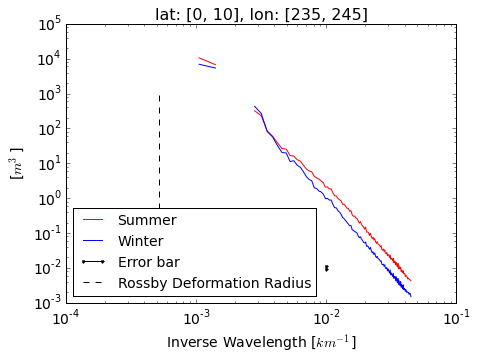

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


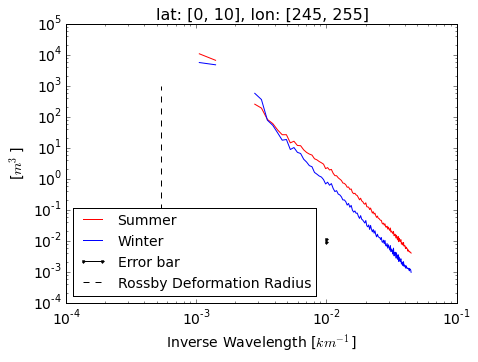

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


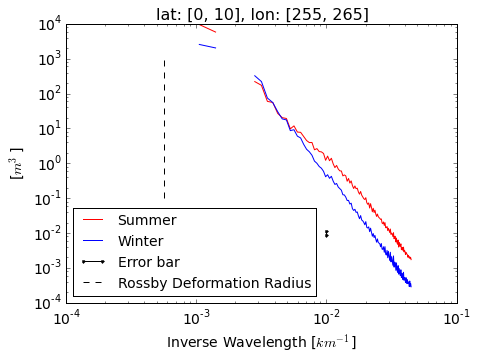

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


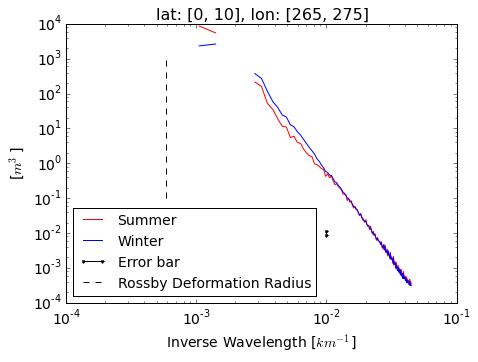

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


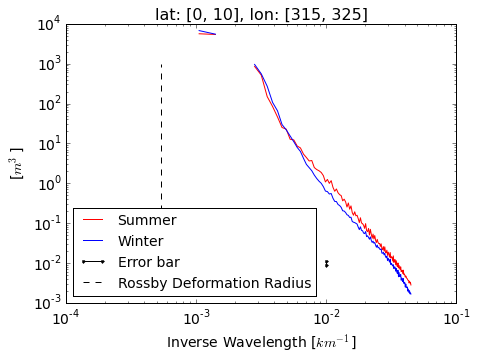

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


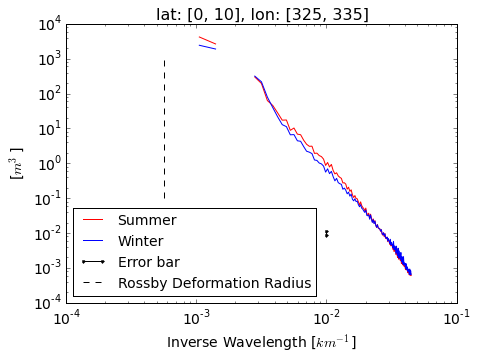

No plot of fit between 0-0.5 radii
No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


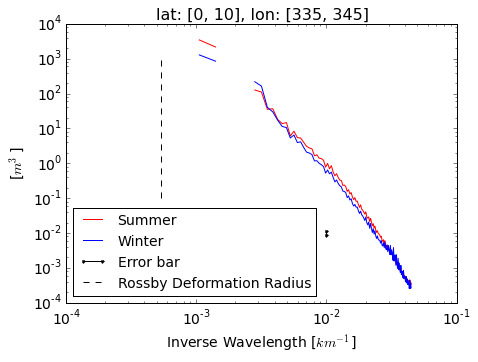

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


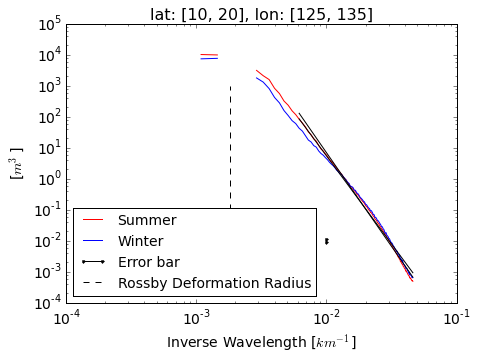

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


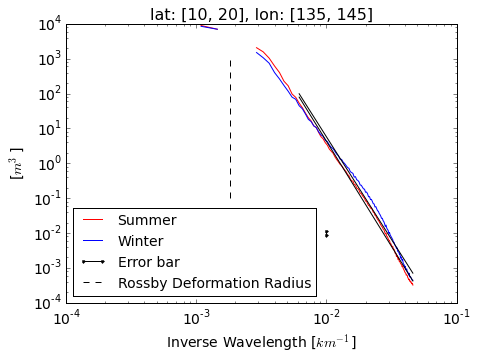

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


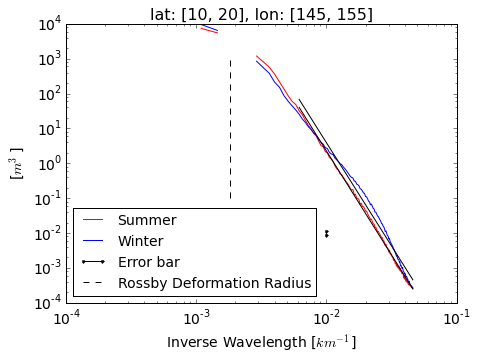

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


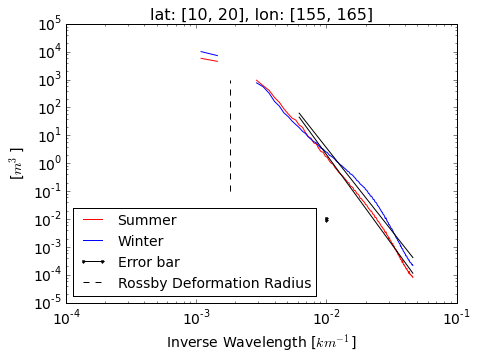

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


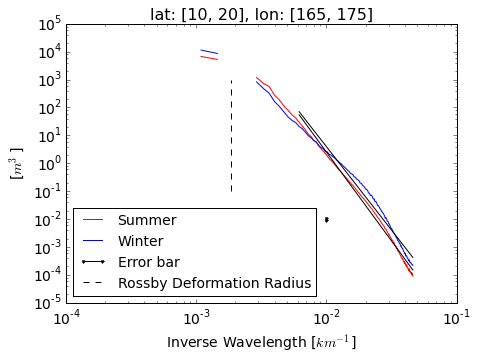

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


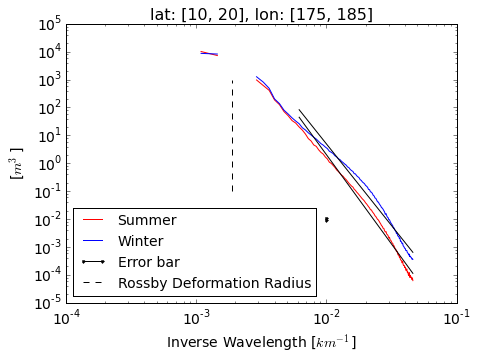

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


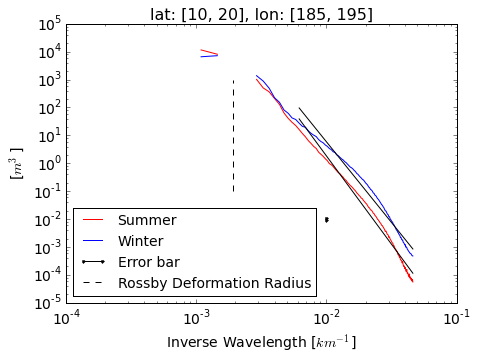

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


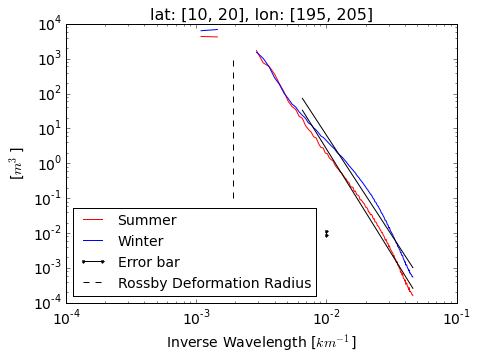

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


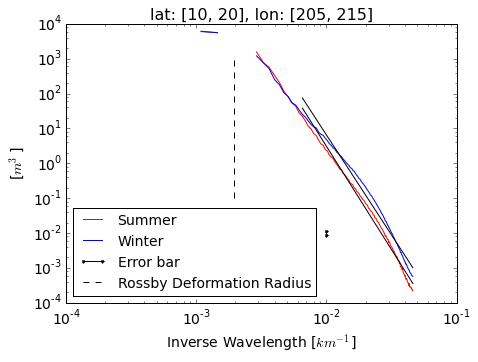

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


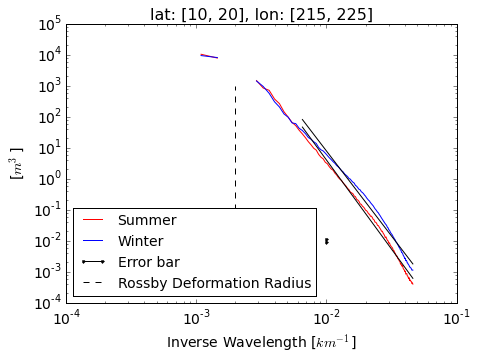

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


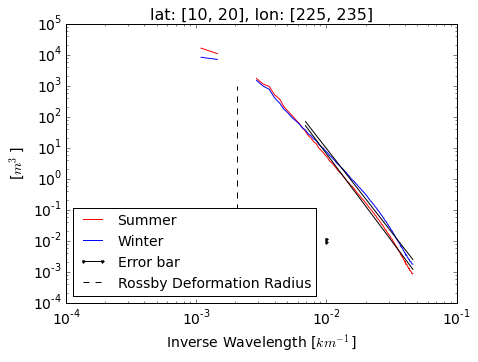

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


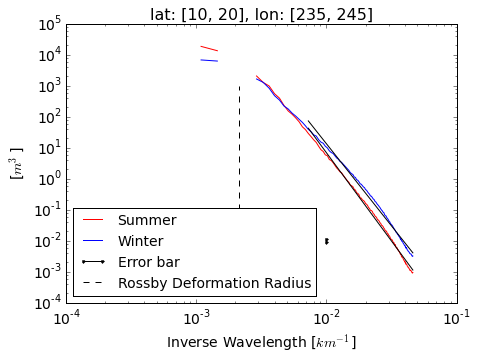

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


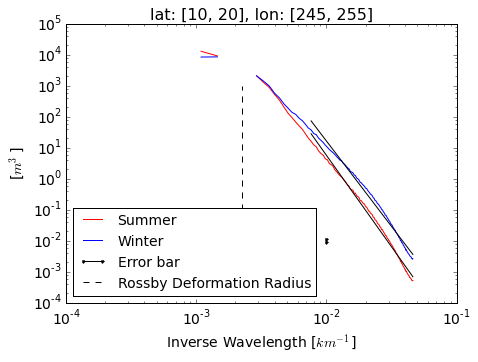

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


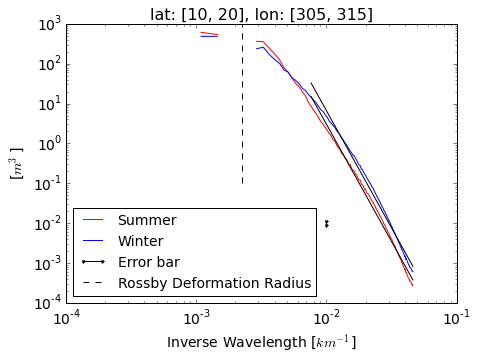

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


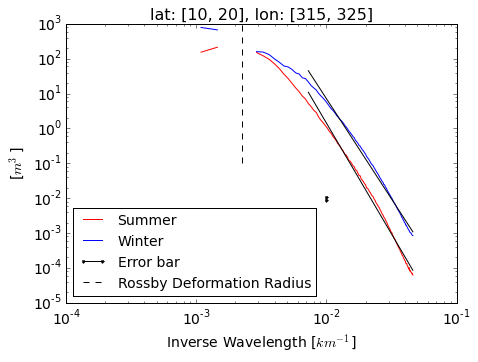

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


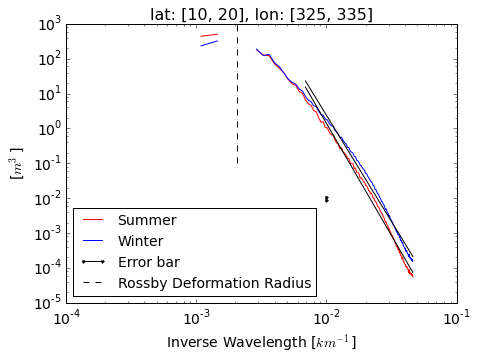

No plot of fit between 1-2 radii


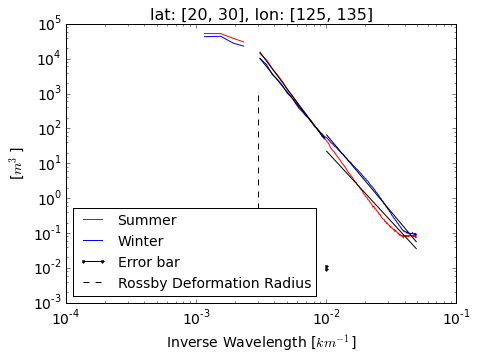

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


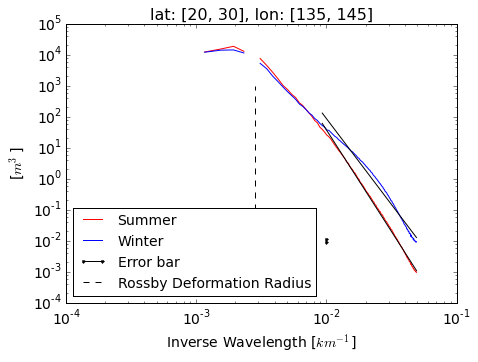

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


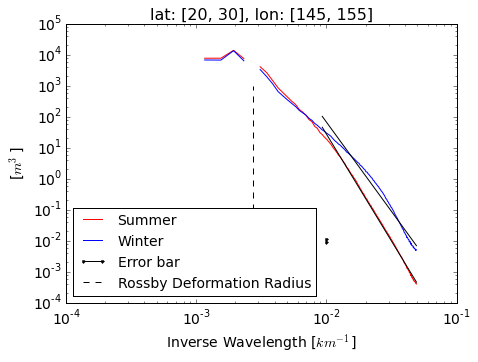

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


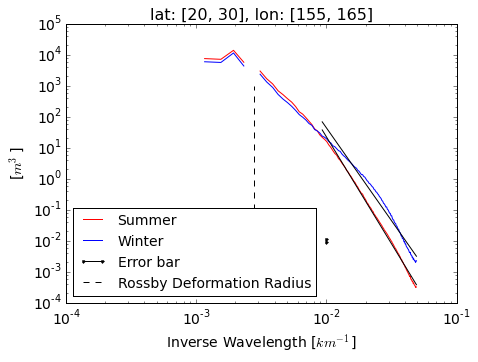

No plot of fit between 0.5-1 radii
No plot of fit between 1-2 radii


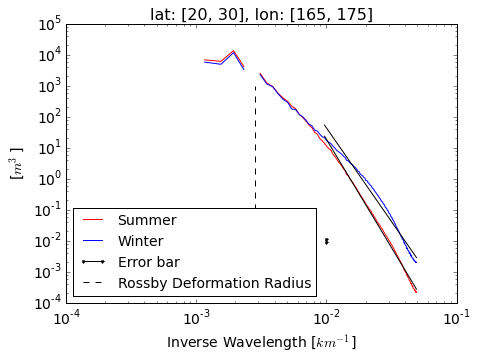

No plot of fit between 1-2 radii


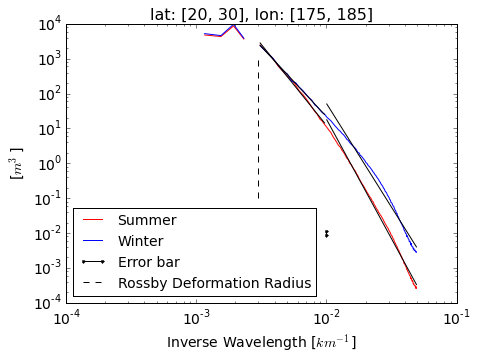

No plot of fit between 1-2 radii


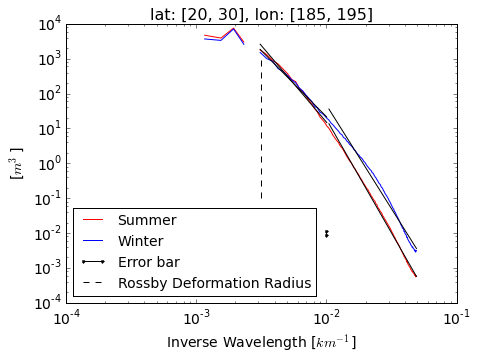

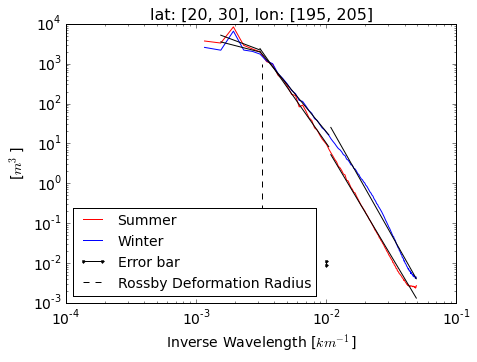

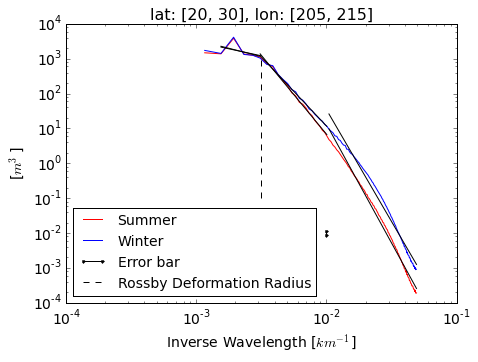

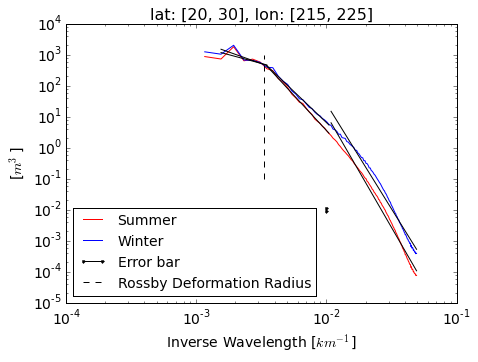

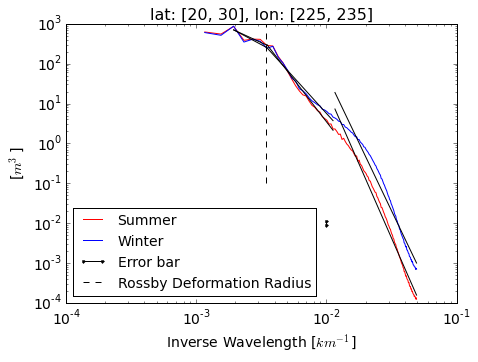

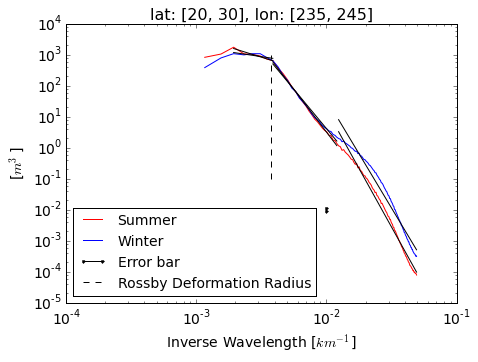

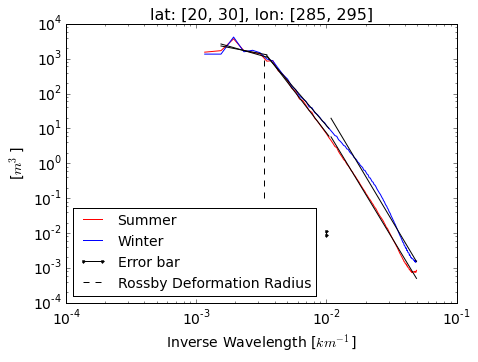

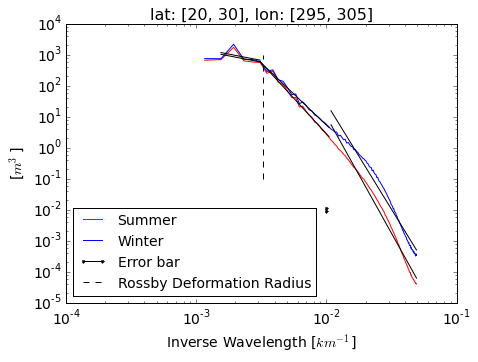

No plot of fit between 1-2 radii


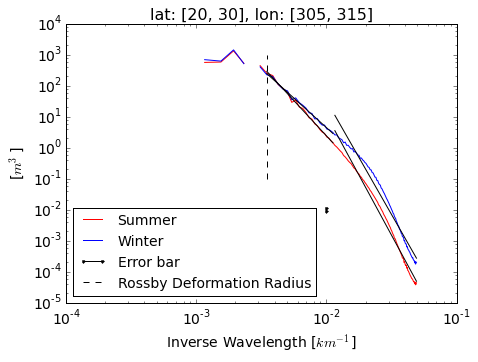

No plot of fit between 1-2 radii


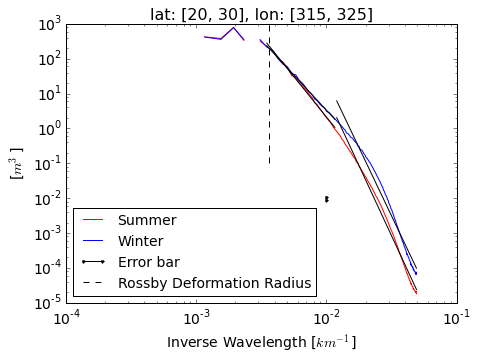

No plot of fit between 1-2 radii


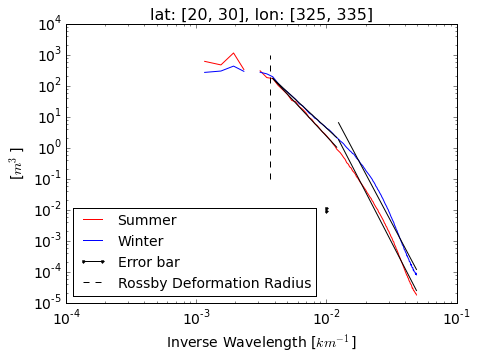

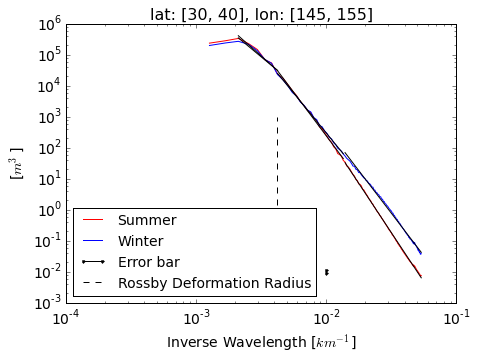

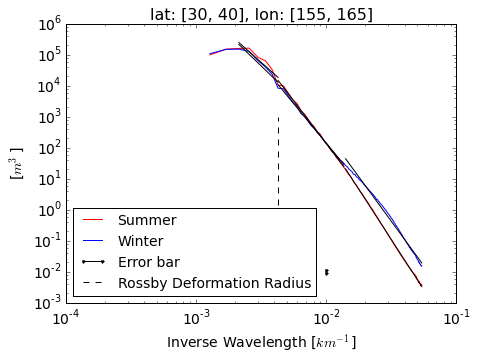

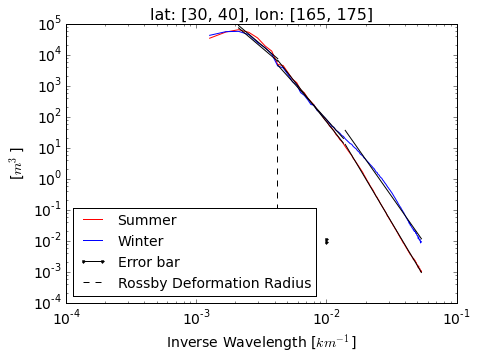

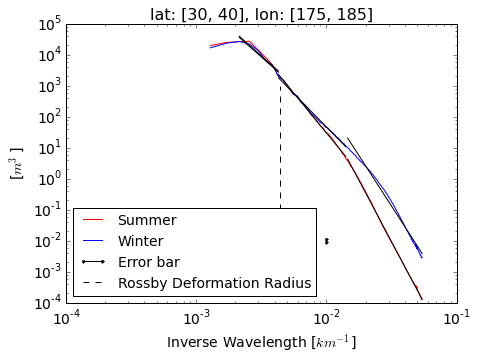

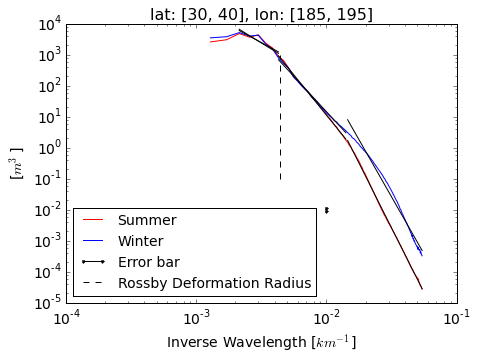

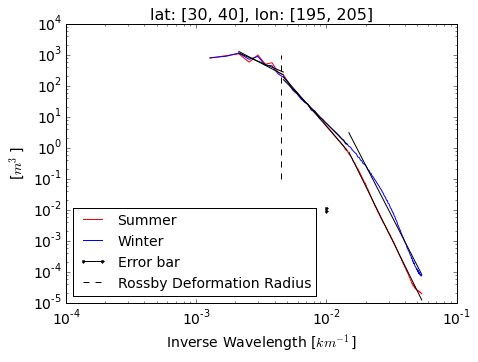

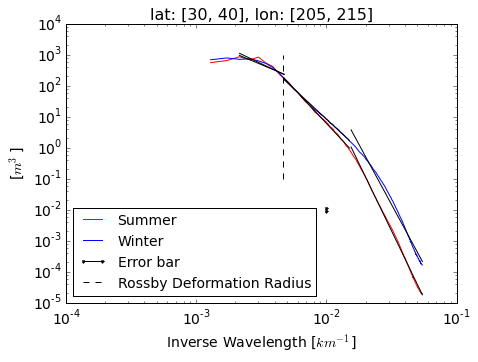

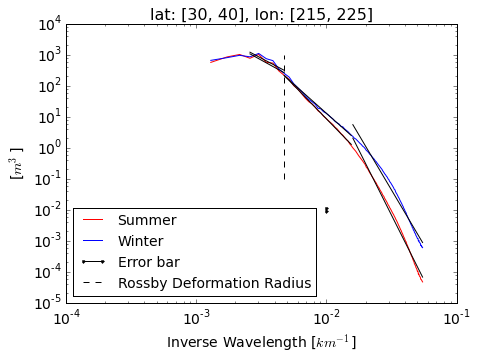

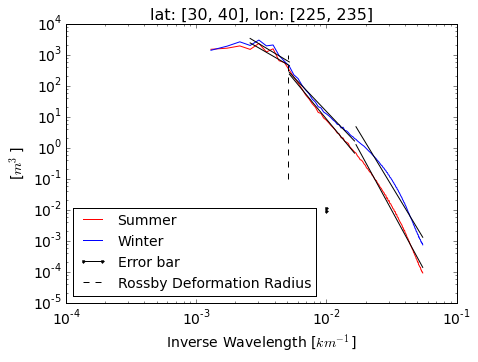

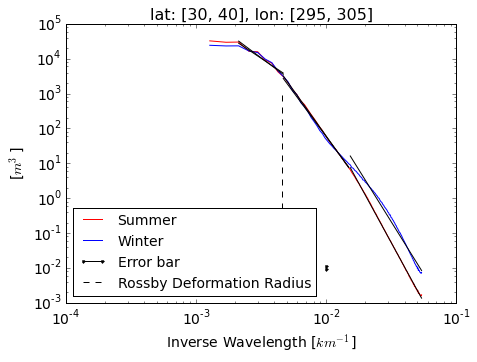

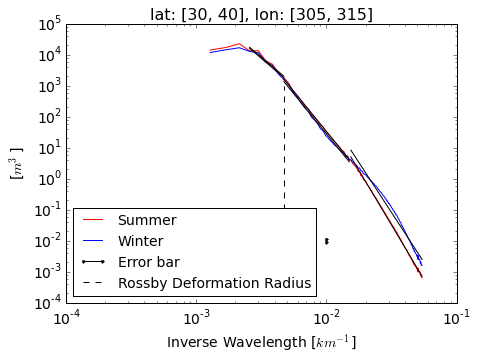

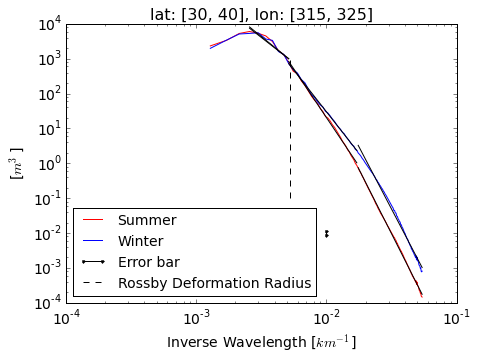

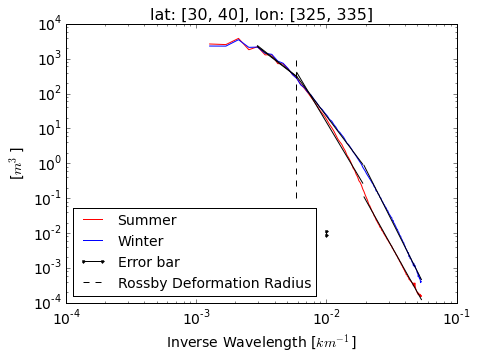

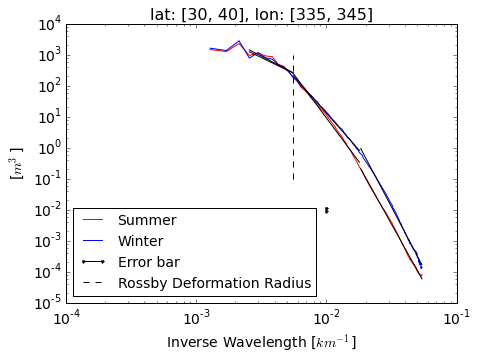

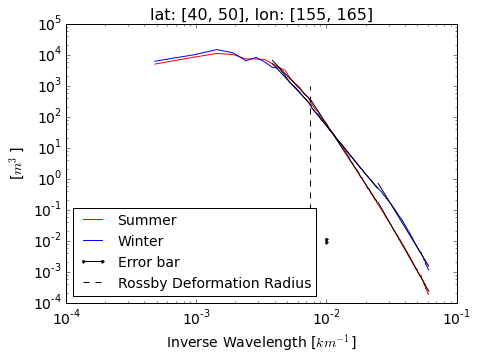

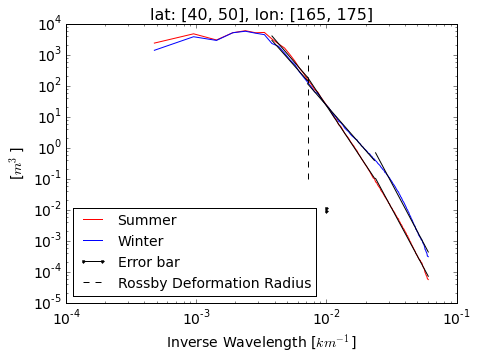

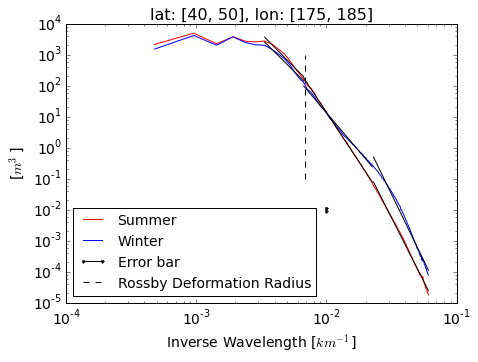

No plot of fit between 1-2 radii


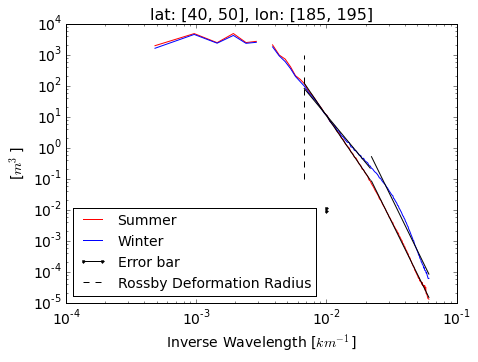

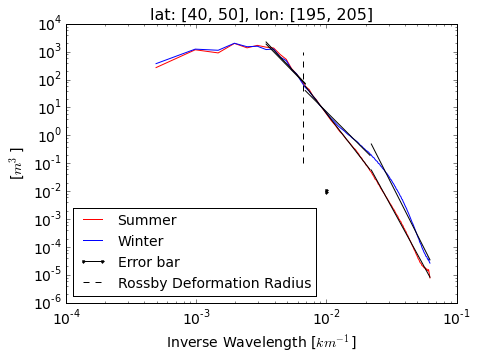

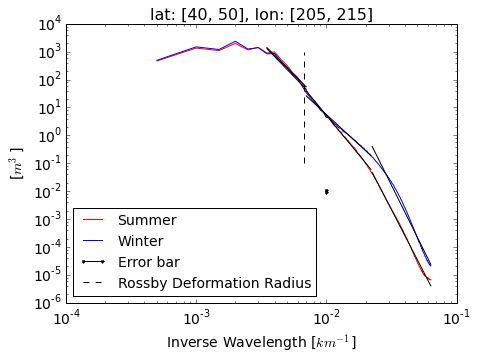

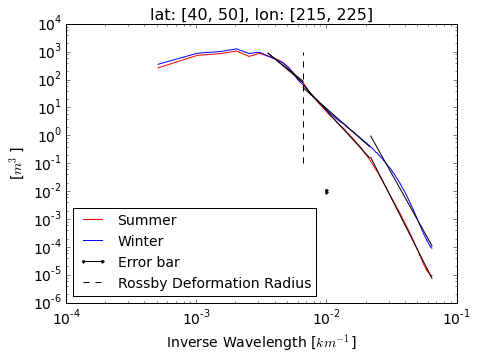

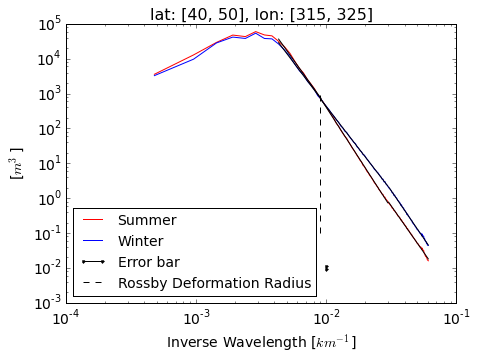

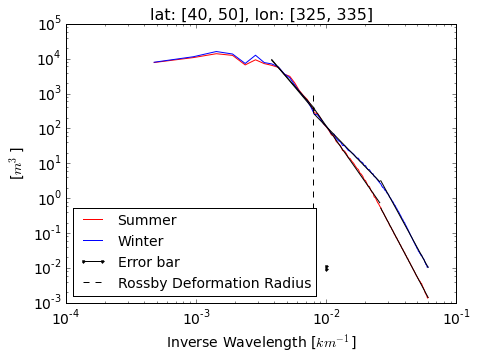

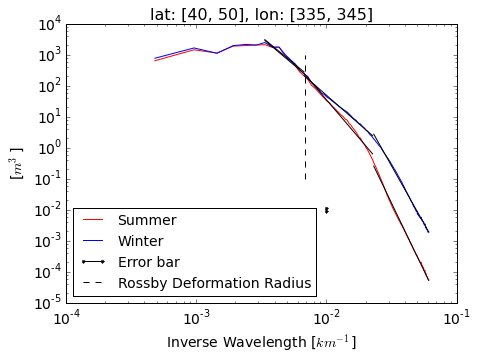

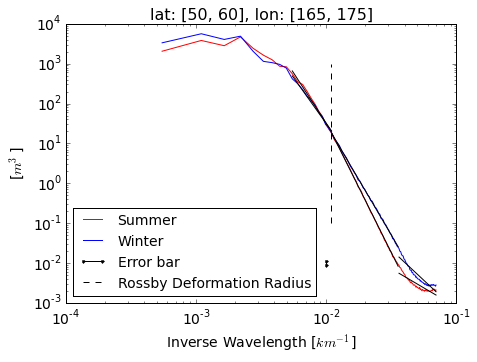

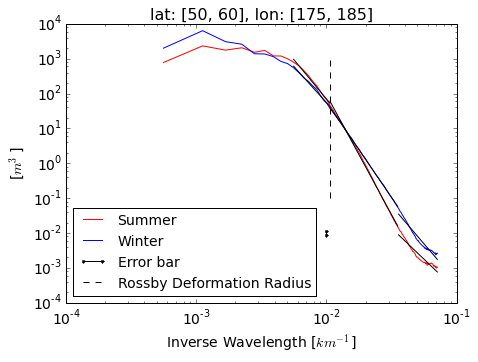

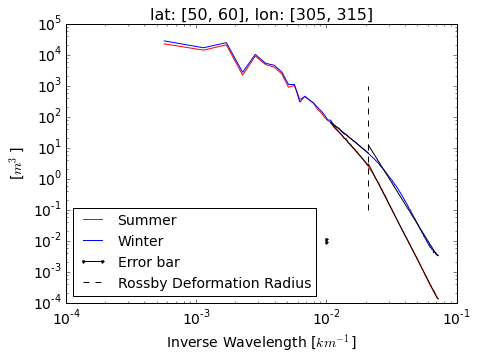

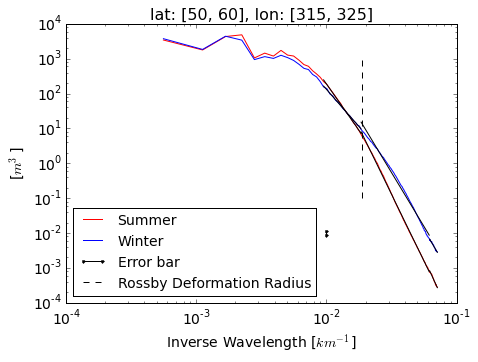

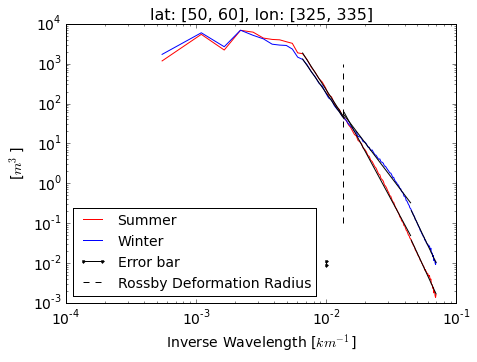

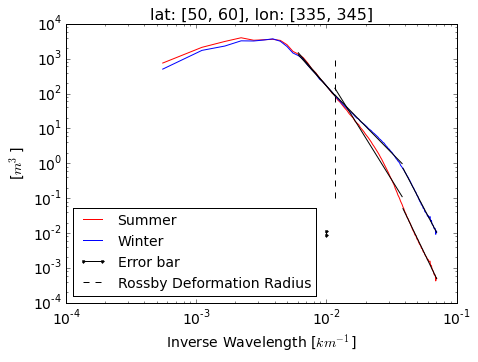

In [49]:
x = 1e-2
A = 1e-2


for j in range(Degy+1):
    for i in range(Degx+1):
        
        Rx = Radii[j,i]*np.ones(100)
        Ry = np.linspace(1e-1, 1e3, 100)
        
        if np.all(np.isnan(isospecs_ave_sum[(Degx+1)*j+i])) == False and np.all(np.isnan(isospecs_ave_win[(Degx+1)*j+i])) == False:
            
            plt.figure(figsize=(7,5))
            #plt.subplot(Degy+1,Degx+1,(Degx+1)*j+i+1)
            plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, isospecs_ave_sum[(Degx+1)*j+i], 'r', label=r'Summer' )
            plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, isospecs_ave_win[(Degx+1)*j+i], 'b', label=r'Winter' )
            plt.loglog([x,x], A*err_bar, 'k.-', label=r'Error bar', basex=10, basey=10) 
            plt.loglog( np.reciprocal(Rx), Ry, 'k--', label=r'Rossby Deformation Radius' )
            
            if np.all( np.isnan(psd_fit_sum_003[:,j,i]) ) == False or np.all( np.isnan(psd_fit_win_003[:,j,i]) ) == False:
                plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_sum_003[:,j,i], 'k' )
                plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_win_003[:,j,i], 'k' )
            else:
                print 'No plot of fit between 0-0.5 radii'
            
            if np.all( np.isnan(psd_fit_sum_031[:,j,i]) ) == False or np.all( np.isnan(psd_fit_win_031[:,j,i]) ) == False:
                plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_sum_031[:,j,i], 'k' )
                plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_win_031[:,j,i], 'k' )
            else:
                print 'No plot of fit between 0.5-1 radii'
                
            if np.all( np.isnan(psd_fit_sum_12[:,j,i]) ) == False or np.all( np.isnan(psd_fit_win_12[:+1,j,i]) ) == False:
                plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_sum_12[:,j,i], 'k' )
                plt.loglog( Kis[(Degx+1)*j+i]*.5/np.pi*1e3, psd_fit_win_12[:,j,i], 'k' )
            else:
                print 'No plot of fit between 1-2 radii'
                
            plt.legend(loc='lower left', fontsize=14)
            plt.title('lat: [%g, %g], lon: [%g, %g]' % (Lat[j,0], Lat[j+1,0], Lon[0,i], Lon[0,i+1]), fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlabel('Inverse Wavelength [$km^{-1}$]', fontsize=14)
            plt.ylabel('[$m^3$]', fontsize=14)
            plt.show()